## Reading in packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
import pathlib
import shutil
import tempfile
import vaex as vx
from IPython import display
from IPython.display import clear_output
import pyodbc
import seaborn as sns

import plotly.graph_objects as go
import ptitprince as pt
from decimal import Decimal

# Tensorflow related
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.compat.v2.feature_column as fc

#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print(tf.__version__)
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
# from utils.generate_features import candleCreateNP_vect_final,\
#                                     generateFeatures_final,\
#                                     generateFeatures_multi_final,
#                                     generateFeatures_multi_v5
from utils.generate_features import generateFeatures_multi_final,\
                                    generateFeatures_multi_v5

# from utils.preprocessing_features_and_labels import extract_labels,\
#                                                     align_features_and_labels,\
#                                                     pre_processing_initial,\
#                                                     pre_processing_extended,\
#                                                     pre_processing_final,\
#                                                     extract_labels_multi_final,\
#                                                     align_features_and_labels_multi_final,\
#                                                     align_features_and_labels_multi_v5

from utils.preprocessing_features_and_labels import pre_processing_final,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final

from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction
from utils.plotting import plot_confusion_matrix
from scipy.stats import kurtosis,skew,spearmanr,kendalltau
sns.set_theme()
sns.set(rc={'figure.figsize':(10,10)})

2.2.0
C:\Users\PC\AppData\Local\Temp\tmpirq3orkd\tensorboard_logs


In [2]:

# pip install ptitprince

In [3]:
# pip install plotly==4.14.1

In [4]:
os.listdir('../../../Desktop')

['Atom.lnk',
 'AU.txt',
 'CryptoExtraction',
 'desktop.ini',
 'exchange-codes.txt',
 'Git-2.27.0-64-bit.exe',
 'Google Drev.lnk',
 'Kristian',
 'Kristian.zip',
 'Mødrup.txt',
 'Pensionsinfo - vejledning.pdf',
 'S0925231217311074.bib',
 'S1877750317309675.bib',
 'S1877750317309675.txt',
 'SissePensionsInfo.pdf',
 'SisseSkat2019.pdf',
 'SupportAssistLauncher.exe',
 'taqquote_20200501.h5',
 'Vejledning til SKAT.pdf']

In [5]:
import seaborn as sns
# sns.set_style(style="darkgrid")

## Extracting data

In [6]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
#     path = 'F:/AggregatedTAQ/round3'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    if int(file) <= 2:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = None,
                           names=['open','high','low','close',
                                  'spread_open','spread_high','spread_low','spread_close',
                                  'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                  'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                  'Ticker'])
        # Using the choice of the user to determine the correct market file
        key = re.split('[_.]',datafiles[int(file)])[-2]
        marketDataFile = [file for file in os.listdir(path+'/round5_market_tickers') if key in file]

        # Reading in the market data
        tempData = pd.read_csv(path+'/round5_market_tickers/'+marketDataFile[0]
                               ,header = None
                               ,names=['open','high','low','close',
                                      'spread_open','spread_high','spread_low','spread_close',
                                      'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                                      'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                                      'Ticker'])
        # Adding the market data to the ticker data
        data = pd.concat([data,tempData],axis=0)
    else:
        data = pd.read_csv(path + '/' + datafiles[int(file)],
                           header = 0,
                           index_col=[0,1]
#                            names=['open','high','low','close',
#                                   'spread_open','spread_high','spread_low','spread_close',
#                                   'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
#                                   'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
#                                   'Ticker']
                          )
    
    # Lower casing all column names
#     data.columns = data.columns.str.lower()
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

# Reading in sector information
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

# Creating a table with stock information based on the tickers available in the data.
uniqueTickers = data.Ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable.head(10)

Which one do you want to load? 

0: aggregateTAQ_May2020_10sec.csv
1: aggregateTAQ_May2020_30sec.csv
2: aggregateTAQ_May2020_60sec.csv
8: trueAggregateTAQ_60sec.csv


8


C:\Users\PC\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
428,APD,Basic Materials,NYQ,5.464395e+10
697,BA,Industrials,NYQ,1.020356e+11
699,BABA,Consumer Cyclical,NYQ,5.936536e+11
700,BAC,Financial Services,NYQ,2.020550e+11
870,BHP,Basic Materials,NYQ,1.258194e+11


# reading in the market data (done automatically atm)

In [7]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385   91.500   91.755   91.485   91.740         0.42         0.93   
         386   91.740   91.740   91.740   91.740         0.50         0.50   
         387   91.580   91.830   91.580   91.715         0.18         0.68   
         388   91.595   91.880   91.595   91.750         0.21         0.78   
         389   46.005   46.005   45.815   45.815        92.01        92.01   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.39          0.50           5.0           5.0   
         386        0.50          0.50           5.0           5.0   
         387        0.18          0.45           5.0           5.0   
         388        0.21          0.52           5.0           5.0   
         389       91.63         91.63           0.0           0.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          5.0            5.0           1.0           5.0   
         386          5.0            5.0           5.0           5.0   
         387          5.0            5.0           1.0           5.0   
         388          5.0            5.0           1.0           5.0   
         389          0.0            0.0           5.0           5.0   

              ofrsize_low  ofrsize_close Ticker      sector  
20200501 0            1.0            4.0   AAPL  Technology  
         1            1.0            1.0   AAPL  Technology  
         2            1.0            1.0   AAPL  Technology  
         3            1.0            1.0   AAPL  Technology  
         4            1.0            1.0   AAPL  Technology  
...                   ...            ...    ...         ...  
20200529 385          1.0            5.0   XNTK         NaN  
         386          5.0            5.0   XNTK         NaN  
         387          1.0            5.0   XNTK         NaN  
         388          1.0            5.0   XNTK         NaN  
         389          1.0            1.0   XNTK         NaN  

[546000 rows x 18 columns]

### Dropping ETFS and market indices

In [8]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY', 'XNTK'], dtype=object)

In [9]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

In [10]:
data.Ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT', 'DIA', 'QQQ', 'SPY'], dtype=object)

In [11]:
# Removing the XNTK ticker
data = data[~data.Ticker.isin(['XNTK'])]

etfs = ['IYH','IYM','IYK','IYJ','IYG','IYW','IYC','IYR','IDU','IYZ','IYE','IYF','SPY','DIA','QQQ']

# Extracting the sector ETFs to a separate variable
sectorETFS = data[data.Ticker.isin(etfs)]

# Removing the ETFs
data = data[~data.Ticker.isin(etfs)]

In [12]:
data.columns

Index(['open', 'high', 'low', 'close', 'spread_open', 'spread_high',
       'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high',
       'bidsize_low', 'bidsize_close', 'ofrsize_open', 'ofrsize_high',
       'ofrsize_low', 'ofrsize_close', 'Ticker', 'sector'],
      dtype='object')

In [13]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker              sector  
20200501 0            1.0            4.0   AAPL          Technology  
         1            1.0            1.0   AAPL          Technology  
         2            1.0            1.0   AAPL          Technology  
         3            1.0            1.0   AAPL          Technology  
         4            1.0            1.0   AAPL          Technology  
...                   ...            ...    ...                 ...  
20200529 385          1.0            1.0    WMT  Consumer Defensive  
         386          1.0            2.0    WMT  Consumer Defensive  
         387          1.0            2.0    WMT  Consumer Defensive  
         388          1.0            4.0    WMT  Consumer Defensive  
         389          1.0            1.0    WMT  Consumer Defensive  

[429000 rows x 18 columns]

# Calculating returns

In [14]:
for i,ticker in enumerate(data.Ticker.unique()):
    
    ## Price series
    temp_price = data[data.Ticker==ticker].close
    
    ## Returns
    simple_ticker_returns = ((temp_price.values[1:]/temp_price.values[:-1]) - 1)
    log_ticker_returns = (np.log(temp_price.values[1:]) - np.log(temp_price.values[:-1]))
    log_abs_ticker_returns = np.abs(log_ticker_returns)
    
    ## Returns over x period 
    simple_ticker_returns_x = [((temp_price.values[i:]/temp_price.values[:-i]) - 1)*100 for i in [3,5,10]]
    log_ticker_returns_x = [(np.log(temp_price.values[i:]) - np.log(temp_price.values[:-i]))*100 for i in [3,5,10]]
    log_abs_ticker_returns_x = np.abs(log_ticker_returns_x)
    
    ##### Autocorrelations
    ## Pearsons
    autocorr_log = np.correlate(log_ticker_returns,
                                log_ticker_returns,
                                mode='full')
    autocorr_log = autocorr_log[autocorr_log.size//2:]
#     if i == 0:
#         print(log_ticker_returns,'\n\n',np.abs(log_ticker_returns))
    autocorr_log_abs = np.correlate(np.abs(log_ticker_returns),
                                np.abs(log_ticker_returns),
                                mode='full')
    autocorr_log_abs = autocorr_log_abs[autocorr_log_abs.size//2:]
    
    autocorr_simple = np.correlate(simple_ticker_returns,
                                   simple_ticker_returns,
                                   mode='full')
    autocorr_simple = autocorr_simple[autocorr_simple.size//2:]
    
    ## Spearmans
    s_auto_log,p_val_l = spearmanr(log_ticker_returns[0:-1],log_ticker_returns[1:])
    s_auto_log_abs,p_val_l_abs = spearmanr(np.abs(log_ticker_returns[0:-1]),np.abs(log_ticker_returns[1:]))
    s_auto_simple,p_val_s = spearmanr(simple_ticker_returns[0:-1],simple_ticker_returns[1:])
    
    ## Kendalls
    k_auto_log,pval_l = kendalltau(log_ticker_returns[0:-1],log_ticker_returns[1:])
    k_auto_log_abs,pval_l_abs = kendalltau(np.abs(log_ticker_returns[0:-1]),np.abs(log_ticker_returns[1:]))
    k_auto_simple,pval_s = kendalltau(simple_ticker_returns[0:-1],simple_ticker_returns[1:])
    
    if i == 0:
        simple_returns = pd.DataFrame()
        log_returns = pd.DataFrame()
        log_abs_returns = pd.DataFrame()
        
        additional_simple = pd.DataFrame(columns=['Kurt','Skew','Corr_P','Corr_S',
                                                  'P_val_S','Corr_K','P_val_K',
                                                  'Avg spread','Med spread','Med Return',
                                                  'Med Return 3','Med Return 5','Med Return 10'])
        
        additional_log = pd.DataFrame(columns=['Kurt','Skew','Corr_P','Corr_S',
                                               'P_val_S','Corr_K','P_val_K',
                                               'Avg spread','Med spread','Med Return',
                                               'Med Return 3','Med Return 5','Med Return 10'])
        
        additional_log_abs = pd.DataFrame(columns=['Kurt','Skew','Corr_P','Corr_S',
                                               'P_val_S','Corr_K','P_val_K',
                                               'Avg spread','Med spread','Med Return'
                                                   ,'Med Return 3','Med Return 5','Med Return 10'])
        
        returns = pd.DataFrame({'simple_returns':simple_ticker_returns,
                                'log_returns':log_ticker_returns,
                                'log_abs_returns':log_abs_ticker_returns})
        returns['ticker'] = ticker
    else:
        temp = pd.DataFrame({'simple_returns':simple_ticker_returns,
                             'log_returns':log_ticker_returns,
                             'log_abs_returns':log_abs_ticker_returns})
        temp['ticker'] = ticker
        returns = pd.concat([returns,temp])
    
    simple_returns.loc[:,ticker] = simple_ticker_returns*100
    log_returns.loc[:,ticker] = log_ticker_returns*100
    log_abs_returns.loc[:,ticker] = log_abs_ticker_returns*100
    
    ## Spread as a percentage of the price
    spread_per_price = (data[data.Ticker==ticker].spread_close/temp_price)*100
    
    additional_simple.loc[ticker,['Kurt','Skew','Corr_P','Corr_S',
                                  'P_val_S','Corr_K','P_val_K',
                                  'Avg spread','Med spread','Med Return',
                                  'Med Return 3','Med Return 5',
                                  'Med Return 10']] = [kurtosis(simple_ticker_returns),
                                                         skew(simple_ticker_returns),
                                                         autocorr_simple[0],
                                                         s_auto_simple,
                                                         p_val_s,
                                                         k_auto_simple,
                                                         pval_s,
                                                         np.mean(spread_per_price),
                                                        np.median(spread_per_price),
                                                       np.median(simple_ticker_returns),
                                                       np.median(simple_ticker_returns_x[0]),
                                                       np.median(simple_ticker_returns_x[1]),
                                                       np.median(simple_ticker_returns_x[2])]
    additional_log.loc[ticker,['Kurt','Skew','Corr_P','Corr_S',
                               'P_val_S','Corr_K','P_val_K',
                               'Avg spread','Med spread','Med Return',
                               'Med Return 3','Med Return 5',
                               'Med Return 10']] = [kurtosis(log_ticker_returns),
                                                     skew(log_ticker_returns),
                                                     autocorr_log[0],
                                                      s_auto_log,
                                                      p_val_l,
                                                      k_auto_log,
                                                      pval_l,
                                                      np.mean(spread_per_price),
                                                     np.median(spread_per_price),
                                                    np.median(log_ticker_returns),
                                                    np.median(log_ticker_returns_x[0]),
                                                    np.median(log_ticker_returns_x[1]),
                                                    np.median(log_ticker_returns_x[2])]
    additional_log_abs.loc[ticker,['Kurt','Skew','Corr_P','Corr_S',
                                   'P_val_S','Corr_K','P_val_K',
                                   'Avg spread','Med spread','Med Return',
                                   'Med Return 3','Med Return 5',
                                   'Med Return 10']] = [kurtosis(log_abs_ticker_returns),
                                                         skew(log_abs_ticker_returns),
                                                         autocorr_log_abs[0],
                                                          s_auto_log_abs,
                                                          p_val_l_abs,
                                                          k_auto_log_abs,
                                                          pval_l_abs,
                                                          np.mean(spread_per_price),
                                                         np.median(spread_per_price),
                                                        np.median(log_abs_ticker_returns),
                                                        np.median(log_abs_ticker_returns_x[0]),
                                                        np.median(log_abs_ticker_returns_x[1]),
                                                        np.median(log_abs_ticker_returns_x[2])]
#         simple_returns = (data.close.values[1:]/data.close.values[0:-1])-1
# log_returns = np.log(data.close.values[1:]) - np.log(data.close.values[0:-1])

INFO:MainThread:numexpr.utils:NumExpr defaulting to 4 threads.


# Adding time

In [15]:
simple_returns.loc[:,'Day'] = data[data.Ticker == 'AAPL'].index[1:].get_level_values(0)

for i,d in enumerate(simple_returns.Day.unique().astype(str)):

    if i == 0:
        number_of_obs = simple_returns[simple_returns.Day == int(d)].shape[0]
        
        container = pd.DataFrame()
        
        container.loc[:,'timestamp'] = pd.date_range(d+' 09:31',periods = number_of_obs,freq='T')
        
    else:
        number_of_obs = simple_returns[simple_returns.Day == int(d)].shape[0]
        
        temp = pd.DataFrame({'timestamp':pd.date_range(d+' 09:30',periods = number_of_obs,freq='T')})
        
        container = pd.concat([container,temp],axis=0)
        
container = container.reset_index(drop=True)

total_obs = simple_returns[simple_returns.Day==20200504].shape[0]
perhour = simple_returns[simple_returns.Day==20200504].shape[0]/6.5
bins_hc = np.linspace(0,perhour*7,8)

# Weekdays
weekdays = {0: 'Monday'
             ,1:'Tuesday'
             ,2:'Wednesday'
             ,3:'Thursday'
             ,4:'Friday'}

# temp_return = log_returns.copy(deep=True)
log_returns.loc[:,'Day'] = data[data.Ticker == 'AAPL'].index[1:].get_level_values(0)
log_returns.loc[:,'Dt'] = pd.to_datetime(log_returns.Day,format='%Y%m%d')
log_returns.loc[:,'Weekday'] = log_returns.Dt.dt.dayofweek.apply(lambda x: weekdays[x])
log_returns.loc[:,'Hour'] = data[data.Ticker == 'AAPL'].index[1:].get_level_values(1)
log_returns.loc[:,'Hour category'] = pd.cut(log_returns.Hour,
                                           bins=bins_hc,#[0,60,120,180,240,300,360,420],
                                           right=True,
                                           include_lowest=True,labels=['09.30-10.30',
                                                                       '10.30-11.30',
                                                                       '11.30-12.30',
                                                                       '12.30-13.30',
                                                                       '13.30-14.30',
                                                                       '14.30-15.30',
                                                                       '15.30-16.00'])
log_returns.loc[:,'H:M'] = container.timestamp.dt.strftime('%H:%M')


simple_returns.loc[:,'Day'] = data[data.Ticker == 'AAPL'].index[1:].get_level_values(0)
simple_returns.loc[:,'Dt'] = pd.to_datetime(log_returns.Day,format='%Y%m%d')
simple_returns.loc[:,'Weekday'] = log_returns.Dt.dt.dayofweek.apply(lambda x: weekdays[x])
simple_returns.loc[:,'Hour'] = data[data.Ticker == 'AAPL'].index[1:].get_level_values(1)
simple_returns.loc[:,'Hour category'] = pd.cut(log_returns.Hour,
                                           bins=bins_hc,#[0,60,120,180,240,300,360,420],
                                           right=True,
                                           include_lowest=True,labels=['09.30-10.30',
                                                                       '10.30-11.30',
                                                                       '11.30-12.30',
                                                                       '12.30-13.30',
                                                                       '13.30-14.30',
                                                                       '14.30-15.30',
                                                                       '15.30-16.00'])
simple_returns.loc[:,'H:M'] = container.timestamp.dt.strftime('%H:%M')

### Prepping to look at other metrics as well
data.loc[:,'Day'] = data.index.get_level_values(0)
data.loc[:,'Dt'] = pd.to_datetime(data.Day,format='%Y%m%d')
data.loc[:,'Weekday'] = data.Dt.dt.dayofweek.apply(lambda x: weekdays[x])
data.loc[:,'Hour'] = data.index.get_level_values(1)
data.loc[:,'Hour category'] = pd.cut(data.Hour,
                                           bins=bins_hc,#[0,60,120,180,240,300,360,420],
                                           right=True,
                                           include_lowest=True,labels=['09.30-10.30',
                                                                       '10.30-11.30',
                                                                       '11.30-12.30',
                                                                       '12.30-13.30',
                                                                       '13.30-14.30',
                                                                       '14.30-15.30',
                                                                       '15.30-16.00'])

## Different from above because the first observation from the first day is needed as well as for all tickers.

for i,d in enumerate(data.index.get_level_values(0).unique().astype(str)):

    if i == 0:
#         number_of_obs = simple_returns[simple_returns.Day == int(d)].shape[0]
        number_of_obs = data.index.get_level_values(1).unique().shape[0]

        container = pd.DataFrame()

        container.loc[:,'timestamp'] = pd.date_range(d+' 09:30',periods = number_of_obs,freq='T')

    else:
#         number_of_obs = simple_returns[simple_returns.Day == int(d)].shape[0]

        temp = pd.DataFrame({'timestamp':pd.date_range(d+' 09:30',periods = number_of_obs,freq='T')})

        container = pd.concat([container,temp],axis=0)
        
container = container.reset_index(drop=True)

for_all_tickers = pd.DataFrame()

for j in np.arange(data.Ticker.unique().shape[0]):
    for_all_tickers = pd.concat([for_all_tickers,container])

for_all_tickers.index = data.index

data.loc[:,'H:M'] = for_all_tickers.timestamp.dt.strftime('%H:%M')
data.loc[:,'Dt_com'] = for_all_tickers.timestamp


log_returns

,AAPL,ABBV,ABT,AEP,AMT,APD,BA,BABA,BAC,BHP,...,UNP,UPS,V,WMT,Day,Dt,Weekday,Hour,Hour category,H:M
0,-0.083005,0.921552,0.000000,-0.121330,0.252953,1.266613,0.368092,0.137206,-0.299401,0.000000,...,-0.460197,0.385997,0.219915,0.037172,20200501,2020-05-01,Friday,1,09.30-10.30,09:31
1,-0.152355,-0.582663,-0.054828,-0.151870,0.678518,0.511132,-0.786908,-0.106699,0.213950,0.012825,...,0.348538,-0.026757,0.196657,0.276295,20200501,2020-05-01,Friday,2,09.30-10.30,09:32
2,0.178301,0.196645,-0.005484,-0.707708,0.008506,-0.488659,0.982671,-0.099180,0.042735,0.089726,...,-0.006384,-0.166055,0.199113,-0.078275,20200501,2020-05-01,Friday,3,09.30-10.30,09:33
3,0.422841,0.116575,0.010969,-0.024493,-0.257614,-0.488800,-0.549808,0.104263,-0.064109,0.064041,...,0.114855,0.026802,0.130630,-0.020609,20200501,2020-05-01,Friday,4,09.30-10.30,09:34
4,-0.080978,-0.055203,-0.071317,-0.098033,0.125696,-0.117488,-0.179252,-0.066106,-0.192575,0.064000,...,-0.226645,-0.456610,0.189961,0.226463,20200501,2020-05-01,Friday,5,09.30-10.30,09:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7794,-0.048563,0.357008,0.235156,0.157798,0.141253,0.109358,-0.078936,0.186294,-0.247678,0.106090,...,-0.047035,0.034950,0.035724,0.120943,20200529,2020-05-29,Friday,385,15.30-16.00,15:55
7795,-0.078377,0.210362,0.319779,0.029195,0.038665,0.020620,-0.030905,-0.099152,0.082628,-0.084863,...,-0.020585,0.004992,-0.096996,-0.084645,20200529,2020-05-29,Friday,386,15.30-16.00,15:56
7796,0.192698,-0.070071,0.255089,-0.105140,0.071490,-0.059810,0.075529,0.120904,-0.123967,0.021222,...,-0.029414,-0.029955,0.030640,0.273829,20200529,2020-05-29,Friday,387,15.30-16.00,15:57
7797,-0.246030,0.123939,0.148502,-0.040918,-0.148834,0.010315,0.106330,0.007250,0.165255,0.021218,...,0.002942,-0.059937,0.000000,-0.209331,20200529,2020-05-29,Friday,388,15.30-16.00,15:58


In [16]:
sns.set_context("paper", font_scale=1.5)

In [17]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  ...  \
20200501 0          0.01          0.24           6.0          95.0  ...   
         1          0.01          0.10           9.0          20.0  ...   
         2          0.01          0.30           1.0          50.0  ...   
         3          0.01          0.17           1.0          25.0  ...   
         4          0.01          0.10          13.0          71.0  ...   
...                  ...           ...           ...           ...  ...   
20200529 385        0.01          0.04           1.0          11.0  ...   
         386        0.01          0.01           1.0           8.0  ...   
         387        0.01          0.05           4.0          16.0  ...   
         388        0.01          0.01           3.0           6.0  ...   
         389        0.01          0.21           1.0          20.0  ...   

              ofrsize_close  Ticker              sector       Day         Dt  \
20200501 0              4.0    AAPL          Technology  20200501 2020-05-01   
         1              1.0    AAPL          Technology  20200501 2020-05-01   
         2              1.0    AAPL          Technology  20200501 2020-05-01   
         3              1.0    AAPL          Technology  20200501 2020-05-01   
         4              1.0    AAPL          Technology  20200501 2020-05-01   
...                     ...     ...                 ...       ...        ...   
20200529 385            1.0     WMT  Consumer Defensive  20200529 2020-05-29   
         386            2.0     WMT  Consumer Defensive  20200529 2020-05-29   
         387            2.0     WMT  Consumer Defensive  20200529 2020-05-29   
         388            4.0     WMT  Consumer Defensive  20200529 2020-05-29   
         389            1.0     WMT  Consumer Defensive  20200529 2020-05-29   

              Weekday Hour Hour category    H:M              Dt_com  
20200501 0     Friday    0   09.30-10.30  09:30 2020-05-01 09:30:00  
         1     Friday    1   09.30-10.30  09:31 2020-05-01 09:31:00  
         2     Friday    2   09.30-10.30  09:32 2020-05-01 09:32:00  
         3     Friday    3   09.30-10.30  09:33 2020-05-01 09:33:00  
         4     Friday    4   09.30-10.30  09:34 2020-05-01 09:34:00  
...               ...  ...           ...    ...                 ...  
20200529 385   Friday  385   15.30-16.00  15:55 2020-05-29 15:55:00  
         386   Friday  386   15.30-16.00  15:56 2020-05-29 15:56:00  
         387   Friday  387   15.30-16.00  15:57 2020-05-29 15:57:00  
         388   Friday  388   15.30-16.00  15:58 2020-05-29 15:58:00  
         389   Friday  389   15.30-16.00  15:59 2020-05-29 15:59:00  

[429000 rows x 25 columns]

In [18]:
subset_data = data.iloc[0:10,:]

In [19]:
subset_data

open     high      low    close  spread_open  spread_high  \
20200501 0  286.250  289.260  285.870  289.260         0.50         0.50   
         1  289.260  289.350  288.365  289.020         0.24         0.45   
         2  289.035  289.705  288.280  288.580         0.07         0.49   
         3  288.485  289.315  288.280  289.095         0.49         0.49   
         4  289.100  290.435  288.940  290.320         0.16         0.33   
         5  290.320  290.440  289.520  290.085         0.10         0.42   
         6  289.990  291.215  289.985  291.110         0.24         0.30   
         7  291.120  291.735  290.610  291.545         0.08         0.34   
         8  291.550  292.170  291.275  292.115         0.08         0.35   
         9  292.095  292.960  291.590  292.580         0.11         0.31   

            spread_low  spread_close  bidsize_open  bidsize_high  ...  \
20200501 0        0.01          0.24           6.0          95.0  ...   
         1        0.01          0.10           9.0          20.0  ...   
         2        0.01          0.30           1.0          50.0  ...   
         3        0.01          0.17           1.0          25.0  ...   
         4        0.01          0.10          13.0          71.0  ...   
         5        0.01          0.05           2.0          86.0  ...   
         6        0.01          0.10           1.0          10.0  ...   
         7        0.01          0.09           1.0          40.0  ...   
         8        0.01          0.15           1.0           6.0  ...   
         9        0.01          0.12           1.0          20.0  ...   

            ofrsize_close  Ticker      sector       Day         Dt  Weekday  \
20200501 0            4.0    AAPL  Technology  20200501 2020-05-01   Friday   
         1            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         2            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         3            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         4            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         5            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         6            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         7            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         8            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         9            1.0    AAPL  Technology  20200501 2020-05-01   Friday   

           Hour Hour category    H:M              Dt_com  
20200501 0    0   09.30-10.30  09:30 2020-05-01 09:30:00  
         1    1   09.30-10.30  09:31 2020-05-01 09:31:00  
         2    2   09.30-10.30  09:32 2020-05-01 09:32:00  
         3    3   09.30-10.30  09:33 2020-05-01 09:33:00  
         4    4   09.30-10.30  09:34 2020-05-01 09:34:00  
         5    5   09.30-10.30  09:35 2020-05-01 09:35:00  
         6    6   09.30-10.30  09:36 2020-05-01 09:36:00  
         7    7   09.30-10.30  09:37 2020-05-01 09:37:00  
         8    8   09.30-10.30  09:38 2020-05-01 09:38:00  
         9    9   09.30-10.30  09:39 2020-05-01 09:39:00  

[10 rows x 25 columns]

# Extracting the first minute of raw tick data

In [20]:
def strList(ls):
    return list(map(lambda x: x.decode('utf-8'),ls))

In [21]:
raw_file = h5py.File('../../../Desktop/'+'taqquote_20200501.h5','r')



In [22]:
print([i for i in raw_file['QuoteIndex'] if 'AAPL' in str(i)[-100:]])

[(b'AAPL             ', 2627943, 3096434)]


In [23]:
temp = pd.DataFrame(raw_file['Quotes'][2627943:2627943+3096434])#)#[698336075:698336075+44570]

temp[['utcsec','ex','bid','bidsize','ofr','ofrsize']]
temp['timestamp'] = pd.to_timedelta(temp.loc[:,'utcsec'])
# temp['date'] = pd.to_datetime('2020-05-01', format='%Y%m%d', errors='ignore')
temp['dtts'] = pd.Timestamp('2020-05-01')+temp.timestamp
temp.loc[:,'ex'] = strList(temp.ex)
# temp['dtts'] = temp.date+temp.timestamp

temp['dtts'] = pd.Timestamp('2020-05-01')+temp.timestamp

In [27]:
np.unique(temp.ex,return_counts=True)

(array(['A', 'B', 'C', 'J', 'K', 'M', 'N', 'P', 'Q', 'V', 'X', 'Y', 'Z'],
       dtype=object),
 array([ 12874,  65828,   2257, 638882, 579626,   1560,  25636, 119078,
        583564,   2283,  37745, 350860, 676241], dtype=int64))

In [54]:
## 6848 - 9771
temp_Q = temp[temp.ex=='Q'].reset_index(drop=True)
oneMinute = temp_Q[(temp_Q.dtts.dt.hour==9)&(temp_Q.dtts.dt.minute==30)][['dtts','utcsec','ex','bid','bidsize','ofr','ofrsize']].copy(deep=True)#.reset_index()

In [55]:
oneMinute

,dtts,utcsec,ex,bid,bidsize,ofr,ofrsize
6848,2020-05-01 09:30:00.004837781,34200004837781,Q,286.00,6,286.50,1
6849,2020-05-01 09:30:00.005036392,34200005036392,Q,286.21,1,286.50,1
6850,2020-05-01 09:30:00.005177925,34200005177925,Q,286.00,6,286.50,1
6851,2020-05-01 09:30:00.005411890,34200005411890,Q,286.21,1,286.50,1
6852,2020-05-01 09:30:00.005963624,34200005963624,Q,286.00,6,286.50,1
...,...,...,...,...,...,...,...
9767,2020-05-01 09:30:59.467221611,34259467221611,Q,289.16,1,289.34,1
9768,2020-05-01 09:30:59.468110337,34259468110337,Q,289.00,1,289.34,1
9769,2020-05-01 09:30:59.484047237,34259484047237,Q,289.00,1,289.38,4
9770,2020-05-01 09:30:59.509150715,34259509150715,Q,289.14,1,289.38,4


In [56]:
#9771
# oneMinute = temp_Q.loc[50:][['dtts','utcsec','ex','bid','bidsize','ofr','ofrsize']].copy(deep=True)#
oneMinute['mid_price'] = (oneMinute.bid+oneMinute.ofr)/2
oneMinute.index = np.arange(0,60,60/oneMinute.shape[0])
oneMinute = oneMinute.reset_index()
# oneMinute = oneminute

In [57]:
oneMinute

,index,dtts,utcsec,ex,bid,bidsize,ofr,ofrsize,mid_price
0,0.000000,2020-05-01 09:30:00.004837781,34200004837781,Q,286.00,6,286.50,1,286.250
1,0.020520,2020-05-01 09:30:00.005036392,34200005036392,Q,286.21,1,286.50,1,286.355
2,0.041040,2020-05-01 09:30:00.005177925,34200005177925,Q,286.00,6,286.50,1,286.250
3,0.061560,2020-05-01 09:30:00.005411890,34200005411890,Q,286.21,1,286.50,1,286.355
4,0.082079,2020-05-01 09:30:00.005963624,34200005963624,Q,286.00,6,286.50,1,286.250
...,...,...,...,...,...,...,...,...,...
2919,59.897401,2020-05-01 09:30:59.467221611,34259467221611,Q,289.16,1,289.34,1,289.250
2920,59.917921,2020-05-01 09:30:59.468110337,34259468110337,Q,289.00,1,289.34,1,289.170
2921,59.938440,2020-05-01 09:30:59.484047237,34259484047237,Q,289.00,1,289.38,4,289.190
2922,59.958960,2020-05-01 09:30:59.509150715,34259509150715,Q,289.14,1,289.38,4,289.260


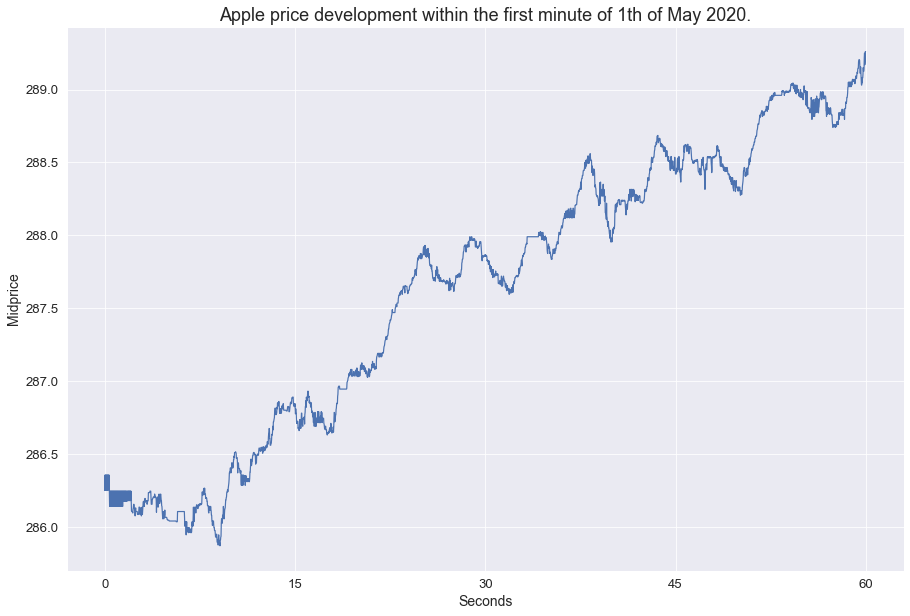

In [46]:
oneMinute.mid_price.plot(figsize=(15,10))
# plt.vertical
plt.xticks(np.arange(0,75,15))
plt.xlabel('Seconds', fontsize=14)
plt.ylabel('Midprice',fontsize=14)
plt.title('Apple price development within the first minute of 1th of May 2020.',fontsize=18)

# plt.savefig('..\..\AppleDevelopment_v2.png',bbox_inches='tight')
plt.show()

In [47]:
from plotly.subplots import make_subplots

In [86]:
low_x = oneMinute.loc[np.where(oneMinute.mid_price.min()==oneMinute.mid_price)[0][0],'index']
low_y = oneMinute.mid_price.min()
high_x = oneMinute.loc[np.where(oneMinute.mid_price.max()==oneMinute.mid_price)[0][0],'index']
high_y = oneMinute.mid_price.max()

In [87]:
low_x

9.090287277701778

In [95]:
subset_data

open     high      low    close  spread_open  spread_high  \
20200501 0  286.250  289.260  285.870  289.260         0.50         0.50   
         1  289.260  289.350  288.365  289.020         0.24         0.45   
         2  289.035  289.705  288.280  288.580         0.07         0.49   
         3  288.485  289.315  288.280  289.095         0.49         0.49   
         4  289.100  290.435  288.940  290.320         0.16         0.33   
         5  290.320  290.440  289.520  290.085         0.10         0.42   
         6  289.990  291.215  289.985  291.110         0.24         0.30   
         7  291.120  291.735  290.610  291.545         0.08         0.34   
         8  291.550  292.170  291.275  292.115         0.08         0.35   
         9  292.095  292.960  291.590  292.580         0.11         0.31   

            spread_low  spread_close  bidsize_open  bidsize_high  ...  \
20200501 0        0.01          0.24           6.0          95.0  ...   
         1        0.01          0.10           9.0          20.0  ...   
         2        0.01          0.30           1.0          50.0  ...   
         3        0.01          0.17           1.0          25.0  ...   
         4        0.01          0.10          13.0          71.0  ...   
         5        0.01          0.05           2.0          86.0  ...   
         6        0.01          0.10           1.0          10.0  ...   
         7        0.01          0.09           1.0          40.0  ...   
         8        0.01          0.15           1.0           6.0  ...   
         9        0.01          0.12           1.0          20.0  ...   

            ofrsize_close  Ticker      sector       Day         Dt  Weekday  \
20200501 0            4.0    AAPL  Technology  20200501 2020-05-01   Friday   
         1            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         2            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         3            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         4            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         5            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         6            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         7            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         8            1.0    AAPL  Technology  20200501 2020-05-01   Friday   
         9            1.0    AAPL  Technology  20200501 2020-05-01   Friday   

           Hour Hour category    H:M              Dt_com  
20200501 0    0   09.30-10.30  09:30 2020-05-01 09:30:00  
         1    1   09.30-10.30  09:31 2020-05-01 09:31:00  
         2    2   09.30-10.30  09:32 2020-05-01 09:32:00  
         3    3   09.30-10.30  09:33 2020-05-01 09:33:00  
         4    4   09.30-10.30  09:34 2020-05-01 09:34:00  
         5    5   09.30-10.30  09:35 2020-05-01 09:35:00  
         6    6   09.30-10.30  09:36 2020-05-01 09:36:00  
         7    7   09.30-10.30  09:37 2020-05-01 09:37:00  
         8    8   09.30-10.30  09:38 2020-05-01 09:38:00  
         9    9   09.30-10.30  09:39 2020-05-01 09:39:00  

[10 rows x 25 columns]

In [118]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=oneMinute.loc[:,'index'], 
                         y=oneMinute.mid_price,
                    mode='lines',
                    name='Intrabar'),
              row=1,col=1)

fig.add_trace(go.Candlestick(x=subset_data['Dt_com'],
                open=subset_data['open'], high=subset_data['high'],
                low=subset_data['low'], close=subset_data['close'],name = 'OHLC Bar')
              ,row = 2, col = 1)

fig.update_layout(width=900, height=500)
fig.update_xaxes(rangeslider= {'visible':False}, row=2, col=1)

## Xaxis

fig['layout']['xaxis1'].update(title='Seconds')
fig['layout']['xaxis2'].update(title='Minutes')

## Yaxis
fig['layout']['yaxis1'].update(title='Price, USD')
fig['layout']['yaxis2'].update(title='Price, USD')
fig['layout']['yaxis1'].update(range=[285.5,293])

fig['layout'].update(
    annotations=[
    dict(
        x=low_x, y=low_y, # annotation point
        xref='x1', 
        yref='y1',
        text='Low: {:.1f}'.format(low_y),
        showarrow=True,
        arrowhead=0,
#         ax=0,
#         ay=30
    ),dict(
        x=high_x, y=high_y, # annotation point
        xref='x1', 
        yref='y1',
        text='High & Close: {:.1f}'.format(high_y),
        showarrow=True,
        arrowhead=0,
#         ax=0,
#         ay=30
    ),dict(
        x=0, y=oneMinute.loc[0,'mid_price'], # annotation point
        xref='x1', 
        yref='y1',
        text='Open: {:.1f}'.format(oneMinute.loc[0,'mid_price']),
        showarrow=True,
        arrowhead=0,
#         ax=0,
#         ay=30
    ),dict(
        x=subset_data.iloc[0,-1], y=subset_data.iloc[0,2], # annotation point
        xref='x2', 
        yref='y2',
        text='Low: {:.1f}'.format(subset_data.iloc[0,2]),
        showarrow=True,
        arrowhead=0,
        ax=60,
        ay=-15
    ),dict(
        x=subset_data.iloc[0,-1], y=subset_data.iloc[0,1], # annotation point
        xref='x2', 
        yref='y2',
        text='High & Close: {:.1f}'.format(subset_data.iloc[0,1]),
        showarrow=True,
        arrowhead=0,
#         ax=0,
#         ay=30
    ),dict(
        x=subset_data.iloc[0,-1], y=subset_data.iloc[0,0], # annotation point
        xref='x2', 
        yref='y2',
        text='Open: {:.1f}'.format(subset_data.iloc[0,0]),
        showarrow=True,
        arrowhead=0,
        ax=-60,
        ay=-20
    )
    ])

fig.show()

In [21]:
########### Generate Features ################

########### Generate Labels ################

n_classes = 3
n_feature_lags = 0
listOfFeatures = [
                    'pastobs',
                    'spread',
                    'bidsize',
                    'ofrsize',
                  'pastreturns',
                  'intradaytime',
                                                    'stok',
                                                    'stod',
#                                                     'sstod',
#                                                     'wilr',
                                                    'roc',
                                                    'rsi',
                                                    'atr',
                                                    'cci',
                                                    'dpo',
                                                    'sma',
                                                    'ema',
                                                    'macd',
                                                      'macd_diff',
                                                      'macd_signal',
                                                    'dis5',
                                                    'dis10',
                      'sector'
                   ]
pastobs_in_percentage = True
label_split = []
# # extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
# price_candles = data[['open','high','low','close','Ticker']]

# ########### Align Data ################

# # from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
# X, y,indices = align_features_and_labels_multi_final(price_candles = price_candles, 
#                                                  all_features = features,
#                                                  prediction_horizon = 1, 
#                                                  n_feature_lags = n_feature_lags, 
#                                                  n_classes = n_classes, # 5,
#                                                  safe_burn_in = False, 
#                                                  data_sample = 'full',
#                                                  splitType='global',
#                                                  noise=False,ticker_dummies=False)

######################################### FROM AZURE #########################################

# features = generateFeatures_multi_final(data = data, 
#                                             listOfFeatures = listOfFeatures, 
#                                             feature_lags = n_feature_lags,
#                                             sectorETFS=sectorETFS,
#                                             pastobs_in_percentage=pastobs_in_percentage)

######################################### New test #########################################

features = generateFeatures_multi_final(data = data, 
                                            listOfFeatures = listOfFeatures, 
                                            feature_lags = n_feature_lags,
                                            sectorETFS=sectorETFS,
                                            pastobs_in_percentage=pastobs_in_percentage)

# features_old = generateFeatures_multi_v5(data = data, 
#                                             listOfFeatures = listOfFeatures, 
#                                             feature_lags = n_feature_lags,
#                                             sectorETFS=sectorETFS,
#                                             pastobs_in_percentage=pastobs_in_percentage)


    ########### Generate Labels ################

price_candles = data[['open','high','low','close','Ticker']].copy(deep=True)

    
print('#################### Aligning features and labels ####################\n')
# blockPrint()
# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y, indices = align_features_and_labels_multi_final(price_candles = price_candles, 
                                                        all_features = features,
                                                        prediction_horizon = 1, 
                                                        n_feature_lags = n_feature_lags, 
                                                        n_classes = n_classes, # 5,
                                                        label_split = label_split,
                                                        safe_burn_in = False, 
                                                        data_sample = 'full',
                                                        splitType='global',
                                                        noise=False,
                                                        ticker_dummies=False)

# X_old, y_old, indices_old = align_features_and_labels_multi_final(price_candles = price_candles, 
#                                                                     all_features = features_old,
#                                                                     prediction_horizon = 1, 
#                                                                     n_feature_lags = n_feature_lags, 
#                                                                     n_classes = n_classes, # 5,
#                                                                     label_split = label_split,
#                                                                     safe_burn_in = False, 
#                                                                     data_sample = 'full',
#                                                                     splitType='global',
#                                                                     noise=False,
#                                                                     ticker_dummies=False)

#################### Aligning features and labels ####################



C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of NaNs in label: 1. 1 is expected
Returns that lead to NaNs in label: [0.0907158]
All tickers processed.


In [24]:
X[X.ticker.isin(['AAPL','BA'])]

,open,high,low,spread_open,spread_high,spread_low,spread_close,bidsize_open,bidsize_high,bidsize_low,...,d_sector_Consumer Cyclical,d_sector_Consumer Defensive,d_sector_Energy,d_sector_Financial Services,d_sector_Healthcare,d_sector_Industrials,d_sector_Real Estate,d_sector_Technology,d_sector_Utilities,ticker
0,0.001419,0.002366,-0.000237,0.000304,0.000641,0.000034,0.000237,3.0,50.0,1.0,...,0,0,0,0,0,0,0,1,0,AAPL
1,-0.001838,0.000692,-0.002142,0.000304,0.000674,0.000034,0.000202,1.0,12.0,1.0,...,0,0,0,0,0,0,0,1,0,AAPL
2,-0.003764,0.000084,-0.004705,0.000169,0.000672,0.000034,0.000235,1.0,14.0,1.0,...,0,0,0,0,0,0,0,1,0,AAPL
3,-0.001175,0.001460,-0.002501,0.000202,0.000570,0.000034,0.000336,1.0,22.0,1.0,...,0,0,0,0,0,0,0,1,0,AAPL
4,-0.000704,0.001627,-0.001811,0.000470,0.000636,0.000034,0.000403,1.0,48.0,1.0,...,0,0,0,0,0,0,0,1,0,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54357,0.002196,0.002401,-0.000515,0.000890,0.001985,0.000069,0.001441,2.0,10.0,1.0,...,0,0,0,1,0,0,0,0,0,BA
54358,0.000481,0.001167,-0.000584,0.000824,0.002263,0.000069,0.001648,4.0,10.0,1.0,...,0,0,0,1,0,0,0,0,0,BA
54359,0.000137,0.001580,-0.000859,0.001305,0.002195,0.000069,0.000206,10.0,18.0,1.0,...,0,0,0,1,0,0,0,0,0,BA
54360,-0.000858,0.001819,-0.001235,0.000412,0.002946,0.000069,0.001167,1.0,7.0,1.0,...,0,0,0,1,0,0,0,0,0,BA


# Exploratory analysis

In [72]:
descriptive_container = pd.DataFrame()
### Actually removes dummies and the benchmark indices
dummy_cols = [col for col in X.columns if (col.startswith('d_',0,2) | (any([i in col for i in ['DIA','SPY','QQQ']])))]

# for ticker in ['AAPL','BA']:
    
#     temp_data = X[X.ticker=='ticker']
    
    

In [23]:
# X.loc[:,[col for col in X.columns if col not in dummy_cols]].describe().T

In [76]:
########################################### Old table ###########################################

# table_data = X.copy(deep=True)#[X.ticker=='AAPL']

# standard_table = table_data.loc[:,[col for col in X.columns if col not in dummy_cols]].describe().T.round(6)
# standard_table.columns = [c.capitalize() for c in standard_table.columns]
# standard_table.loc[:,'Median'] = table_data.iloc[:,:-1].apply(lambda x: np.median(x)).round(6)

# ## Correcting decimals
# for i in standard_table.index:
    
#     if ('spread' in i)|('relReturns' in i)|('pastreturn' in i):
        
#         standard_table.loc[i,:] = standard_table.loc[i,:].apply(lambda x: '%.2e' % Decimal(x) if x != 0 else 0)
#     elif 'size' in i:
#         for c in ['Median','Min','25%','75%','Max']:
#             standard_table.loc[i,c] = int(standard_table.loc[i,c])
#     else:
# #         print(i)
#         standard_table.loc[i,:] = standard_table.loc[i,:].apply(lambda x: '%.3f' % Decimal(x) if type(x) == float else x)

# standard_table.loc[:,'S'] = table_data.iloc[:,:-1].apply(lambda x: skew(x)).round(3)
# standard_table.loc[:,'K'] = table_data.iloc[:,:-1].apply(lambda x: kurtosis(x)).round(3)
    
# standard_table = standard_table.loc[:,['Count','Mean','Median','Std','S','K','Min','25%','75%','Max']]#,'50%'
# standard_table.loc[:,'Count'] = int(float(standard_table.iloc[0,0]))

# ### Setting correct indices
# new_indices = []

# for i in standard_table.index:

#     if i in ['open','high','low']:
#         new_indices.append(i.capitalize())
#     elif 'bid' in i:
#         new_indices.append(i.capitalize().replace('_',' '))
#     elif 'ofrsize' in i:
#         new_indices.append('Asksize '+re.split('_',i)[-1])
#     elif i in ['EMA','SMA']:
#         new_indices.append('P'+i[0:2])
#     elif len(i) == 3:
# #         varname = columns[j+l].upper()
#         new_indices.append(i.upper())
#     elif i in ['stok','stod']:
#         new_indices.append(i[0:3].capitalize()+'^{%s}'%i[-1])
#     elif i in ['dis5','dis10']:
#         new_indices.append(i[0:3].capitalize()+'_{%s}'%i[-1] if len(i)==4 else i[0:3].capitalize()+'_{%s}'%i[-2:])
#     elif 'macd' in i:
#         split = re.split('_',i)
# #                         varname = split[0].upper()+' '+split[-1] if len(columns[j+l])>4 else columns[j+l].upper()
#         new_indices.append(split[0].upper()+'_{%s}'%split[-1].capitalize() if len(i)>4 else i.upper()+'_{%s}'%'Spread')
#     elif 'relReturns' in i:
#         new_indices.append(re.split('_',i)[-1])
#     else:
#         new_indices.append(i.capitalize())
    
# standard_table.index = new_indices

# standard_table.rename(columns={'S':'s_3','K':'\kappa'})

########################################### New table ###########################################

table_data = X.copy(deep=True)#[X.ticker=='AAPL']

standard_table = table_data.loc[:,[col for col in X.columns if col not in dummy_cols]].describe().T.round(6)
standard_table.columns = [c.capitalize() for c in standard_table.columns]
standard_table.loc[:,'Median'] = table_data.iloc[:,:-1].apply(lambda x: np.median(x)).round(6)

# print(standard_table.index)

## Correcting decimals
for i in standard_table.index:
    
    if ('spread' in i):
        
        standard_table.loc[i,:] = (standard_table.loc[i,:]*100).apply(lambda x: '%.2f' % Decimal(x))
    elif ('return' in i.lower()):
        
        standard_table.loc[i,:] = (standard_table.loc[i,:].astype(float)*10000).apply(lambda x: '%.2f' % Decimal(x))
    elif (i in ['open','high','low']) & pastobs_in_percentage:
        
        standard_table.loc[i,:] = (standard_table.loc[i,:]*100).apply(lambda x: '%.2f' % Decimal(x))    
    else:

        standard_table.loc[i,:] = standard_table.loc[i,:].apply(lambda x: '%.2f' % Decimal(x))

standard_table.loc[:,'S'] = table_data.iloc[:,:-1].apply(lambda x: skew(x)).round(2)
standard_table.loc[:,'K'] = table_data.iloc[:,:-1].apply(lambda x: kurtosis(x)).round(2)
    
standard_table = standard_table.loc[:,['Mean','Median','Std','S','K','Min','25%','75%','Max']]#,'50%','Count',
# standard_table.loc[:,'Count'] = int(float(standard_table.iloc[0,0]))

### Setting correct indices
new_indices = []

for i in standard_table.index:

    if i in ['open','high','low']:
        new_indices.append(i.capitalize())
    elif 'bid' in i:
        new_indices.append(i.capitalize().replace('_',' '))
    elif 'ofrsize' in i:
        new_indices.append('Asksize '+re.split('_',i)[-1])
    elif i in ['EMA','SMA']:
        new_indices.append('P'+i[0:2])
    elif len(i) == 3:
        new_indices.append(i.upper())
    elif i in ['stok','stod']:
        new_indices.append(i[0:3].capitalize()+'^{%s}'%i[-1])
    elif i in ['dis5','dis10']:
        new_indices.append(i[0:3].capitalize()+'_{%s}'%i[-1] if len(i)==4 else i[0:3].capitalize()+'_{%s}'%i[-2:])
    elif 'macd' in i:
        split = re.split('_',i)
        new_indices.append(split[0].upper()+'_{%s}'%split[-1].capitalize() if len(i)>4 else i.upper()+'_{%s}'%'Spread')
    elif 'relReturns' in i:
        new_indices.append(re.split('_',i)[-1])
    else:
        new_indices.append(i.capitalize())
    
standard_table.index = new_indices

standard_table.rename(columns={'S':'s_3','K':'\kappa'})

,Mean,Median,Std,s_3,\kappa,Min,25%,75%,Max
Open,0.00,0.00,0.10,0.70,72.23,-4.51,-0.04,0.04,5.36
High,0.06,0.04,0.09,6.63,170.98,0.00,0.01,0.08,5.94
Low,-0.06,-0.04,0.08,-5.35,87.94,-4.51,-0.08,-0.01,0.00
Spread_open,0.09,0.04,0.18,17.52,796.82,0.00,0.02,0.09,16.02
Spread_high,0.16,0.09,0.24,10.57,295.29,0.01,0.06,0.16,15.86
Spread_low,0.04,0.02,0.08,11.43,262.72,0.00,0.01,0.04,4.37
Spread_close,0.08,0.04,0.15,8.07,129.14,0.00,0.02,0.09,6.06
Bidsize open,11.43,1.00,53.27,9.31,110.66,1.00,1.00,3.00,1947.00
Bidsize high,33.42,6.00,130.06,8.29,93.25,1.00,3.00,13.00,5163.00
Bidsize low,2.83,1.00,23.26,21.12,550.64,1.00,1.00,1.00,1152.00


In [85]:
dummy_cols = [col for col in X.columns if (col.startswith('d_',0,2) | (any([i in col for i in ['DIA','SPY','QQQ']])))]
reduced_data = pd.concat([X.loc[:,[col for col in X.columns if col not in dummy_cols]].copy(deep=True),
    y.copy(deep=True).rename(columns={0:'PC'}).astype(int)],axis=1)

In [57]:
reduced_data.columns

Index(['open', 'high', 'low', 'spread_open', 'spread_high', 'spread_low',
       'spread_close', 'bidsize_open', 'bidsize_high', 'bidsize_low',
       'bidsize_close', 'ofrsize_open', 'ofrsize_high', 'ofrsize_low',
       'ofrsize_close', 'pastreturns', 'intradaytime', 'stok', 'stod', 'roc',
       'rsi', 'atr', 'cci', 'dpo', 'sma', 'ema', 'macd', 'macd_diff',
       'macd_signal', 'dis5', 'dis10', 'relReturns_IDU', 'relReturns_IYC',
       'relReturns_IYE', 'relReturns_IYG', 'relReturns_IYH', 'relReturns_IYJ',
       'relReturns_IYK', 'relReturns_IYM', 'relReturns_IYR', 'relReturns_IYW',
       'relReturns_IYZ', 'ticker', 'PC'],
      dtype='object')

In [86]:
reduced_data

,open,high,low,spread_open,spread_high,spread_low,spread_close,bidsize_open,bidsize_high,bidsize_low,...,relReturns_IYG,relReturns_IYH,relReturns_IYJ,relReturns_IYK,relReturns_IYM,relReturns_IYR,relReturns_IYW,relReturns_IYZ,ticker,PC
0,0.001419,0.002366,-0.000237,0.000304,0.000641,0.000034,0.000237,3.0,50.0,1.0,...,-0.000290,-0.000253,-0.000362,0.000332,-0.000521,-0.000315,0.000069,-0.001030,AAPL,2
1,-0.001838,0.000692,-0.002142,0.000304,0.000674,0.000034,0.000202,1.0,12.0,1.0,...,0.002143,0.001708,0.002099,0.002172,0.001750,0.001740,0.001205,0.001690,AAPL,2
2,-0.003764,0.000084,-0.004705,0.000169,0.000672,0.000034,0.000235,1.0,14.0,1.0,...,0.002638,0.004202,0.003126,0.003583,0.002790,0.003116,0.002519,0.003239,AAPL,2
3,-0.001175,0.001460,-0.002501,0.000202,0.000570,0.000034,0.000336,1.0,22.0,1.0,...,0.000704,0.001121,0.000748,0.000092,0.001507,-0.000233,0.000005,0.001193,AAPL,2
4,-0.000704,0.001627,-0.001811,0.000470,0.000636,0.000034,0.000403,1.0,48.0,1.0,...,0.000949,0.001069,0.001751,0.000680,0.002396,-0.001328,0.000724,0.001008,AAPL,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427125,-0.000887,0.000081,-0.001412,0.000161,0.000565,0.000081,0.000161,3.0,6.0,1.0,...,0.001718,0.000961,0.000983,0.000287,0.001247,0.000590,0.001046,-0.000045,WMT,2
427126,-0.001209,0.000081,-0.001531,0.000161,0.000564,0.000081,0.000322,1.0,11.0,1.0,...,0.002081,-0.000012,0.001210,-0.000873,-0.000388,-0.000597,0.000973,-0.002536,WMT,0
427127,0.000726,0.000726,-0.000605,0.000081,0.000484,0.000081,0.000081,1.0,8.0,1.0,...,-0.000306,-0.000778,-0.000204,-0.000686,-0.000276,-0.000460,-0.000054,-0.001557,WMT,2
427128,-0.002735,0.000161,-0.002815,0.000081,0.000563,0.000081,0.000402,4.0,16.0,1.0,...,0.002617,0.002652,0.001964,0.003062,0.002286,0.002742,0.001989,0.003097,WMT,0


In [58]:
## Variable sets

colors = {'base':'Blues','sector':'Greens','technical':'Purples'}

variable_sets = ['base','sector','technical']



# variable_sets = {{'base':{'open':'Difference to close price',
#                           'high':'Difference to close price',
#                           'low':'Difference to close price',
#                           'spread_open': 'Normalised by the open price',
#                           'spread_high': 'Normalised by the high price',
#                           'spread_low': 'Normalised by the low price',
#                           'spread_close': 'Normalised by the close price',
#                           'bidsize_open': 'Number of stocks, hundreds',
#                           'bidsize_high': 'Number of stocks, hundreds',
#                           'bidsize_low': 'Number of stocks, hundreds',
#                           'bidsize_close': 'Number of stocks, hundreds',
#                           'ofrsize_open': 'Number of stocks, hundreds',
#                           'ofrsize_high':'Number of stocks, hundreds',
#                           'ofrsize_low':'Number of stocks, hundreds',
#                           'ofrsize_close':'Number of stocks, hundreds',
#                           'pastreturns': 'Percentage',
#                           'intradaytime':'Demeaned intraday time'}},
#                  {'sector':{'relReturns_IDU':'Relative return to U.S. Utilities sector ETF',
#                             'relReturns_IYC':'Relative return to U.S. Consumer Service sector ETF',
#                             'relReturns_IYE':'Relative return to U.S. Energy sector ETF',
#                             'relReturns_IYG':'Relative return to U.S. Financial Services sector ETF',
#                             'relReturns_IYH':'Relative return to U.S. Healthcare sector ETF',
#                             'relReturns_IYJ':'Relative return to U.S. Industrials sector ETF',
#                             'relReturns_IYK':'Relative return to U.S. Consumer Goods sector ETF',
#                             'relReturns_IYM':'Relative return to U.S. Base Materials sector ETF', 
#                             'relReturns_IYR':'Relative return to U.S. Real Estate sector ETF',
#                             'relReturns_IYW':'Relative return to U.S. Technology sector ETF',
#                             'relReturns_IYZ':'Relative return to U.S. Telecommunications sector ETF'}},
#                  {'technical':{'sma':'Difference to close price', 
#                                'ema':'Difference to close price',
#                                'stok':'Ratio', 
#                                'stod':'Ratio', 
#                                'roc':'Relative difference',
#                                'rsi':'Ratio*', 
#                                'atr':'Smoothed difference', 
#                                'cci':'Ratio', 
#                                'dpo':'Difference to close price', 
#                                'macd': 'Difference', 
#                                'macd_diff':'Difference',
#                                'macd_signal':'Smoothed change', 
#                                'dis5':'Relative difference', 
#                                'dis10':'Relative difference'}}}

# Unconditional

In [ ]:
save_plots = True
save_path = '../../../Google Drev/Thesis/Figures/variables'#'../../Figures_Thesis/model_params'
save_date = '20201224'
add_on_name = 'Full_data'#3_cols_full_data

cols = 3

plot_full_data = True
ticker_of_interest = 'AAPL'

if plot_full_data:
    ticker_to_plot = reduced_data.copy(deep=True)
else:
    ticker_to_plot = reduced_data[reduced_data.ticker==ticker_of_interest].copy(deep=True)

sns.set_context("paper", font_scale=2)

for var_set in variable_sets:
    if var_set == 'base':
        vs = {'open':'Difference to close price',
                          'high':'Difference to close price',
                          'low':'Difference to close price',
                          'spread_open': 'Normalised by the open price',
                          'spread_high': 'Normalised by the high price',
                          'spread_low': 'Normalised by the low price',
                          'spread_close': 'Normalised by the close price',
                          'bidsize_open': 'Number of stocks, hundreds',
                          'bidsize_high': 'Number of stocks, hundreds',
#                           'bidsize_low': 'Number of stocks, hundreds',
                          'bidsize_close': 'Number of stocks, hundreds',
                          'ofrsize_open': 'Number of stocks, hundreds',
                          'ofrsize_high':'Number of stocks, hundreds',
#                           'ofrsize_low':'Number of stocks, hundreds',
                          'ofrsize_close':'Number of stocks, hundreds',
                          'pastreturns': 'Percentage',
                          'intradaytime':'Demeaned intraday time'}
    elif var_set == 'sector':
#         vs = {'relReturns_IDU':'Relative return to U.S. Utilities sector ETF',
#                             'relReturns_IYC':'Relative return to U.S. Consumer Service sector ETF',
#                             'relReturns_IYE':'Relative return to U.S. Energy sector ETF',
#                             'relReturns_IYG':'Relative return to U.S. Financial Services sector ETF',
#                             'relReturns_IYH':'Relative return to U.S. Healthcare sector ETF',
#                             'relReturns_IYJ':'Relative return to U.S. Industrials sector ETF',
#                             'relReturns_IYK':'Relative return to U.S. Consumer Goods sector ETF',
#                             'relReturns_IYM':'Relative return to U.S. Base Materials sector ETF', 
#                             'relReturns_IYR':'Relative return to U.S. Real Estate sector ETF',
#                             'relReturns_IYW':'Relative return to U.S. Technology sector ETF',
#                             'relReturns_IYZ':'Relative return to U.S. Telecommunications sector ETF'}
        vs = {'relReturns_IDU':'Difference (%-points)',
                            'relReturns_IYC':'Difference (Rel. diff. points)',
                            'relReturns_IYE':'Difference (Rel. diff. points)',
                            'relReturns_IYG':'Difference (Rel. diff. points)',
                            'relReturns_IYH':'Difference (Rel. diff. points)',
                            'relReturns_IYJ':'Difference (Rel. diff. points)',
                            'relReturns_IYK':'Difference (Rel. diff. points)',
                            'relReturns_IYM':'Difference (Rel. diff. points)', 
                            'relReturns_IYR':'Difference (Rel. diff. points)',
                            'relReturns_IYW':'Difference (Rel. diff. points)',
                            'relReturns_IYZ':'Difference (Rel. diff. points)'}
        add_on = {'relReturns_IDU':'(U.S. Utilities ETF)',
                            'relReturns_IYC':'(U.S. Consumer Ser. ETF)',
                            'relReturns_IYE':'(U.S. Energy ETF)',
                            'relReturns_IYG':'(U.S. Financial Ser. ETF)',
                            'relReturns_IYH':'(U.S. Healthcare ETF)',
                            'relReturns_IYJ':'(U.S. Industrials ETF)',
                            'relReturns_IYK':'(U.S. Consumer Goods ETF)',
                            'relReturns_IYM':'(U.S. Base Materials  ETF)', 
                            'relReturns_IYR':'(U.S. Real Estate ETF)',
                            'relReturns_IYW':'(U.S. Technology ETF)',
                            'relReturns_IYZ':'(U.S. Telecom. ETF)'}
    else:
        vs = {'sma':'Difference to close price', 
                               'ema':'Difference to close price',
                               'stok':'Ratio', 
                               'stod':'Ratio', 
                               'roc':'Relative difference',
                               'rsi':'Ratio*', 
                               'atr':'Smoothed difference', 
                               'cci':'Ratio', 
                               'dpo':'Difference to close price', 
                               'macd': 'Difference', 
                               'macd_diff':'Difference',
                               'macd_signal':'Smoothed change', 
                               'dis5':'Relative difference', 
                               'dis10':'Relative difference'}
        
    print('Visualisation of '+var_set+'\n')

    numb_of_vars = len(list(vs.keys()))

    fig, axes = plt.subplots(int(np.ceil(numb_of_vars/cols)),
                             cols,
                             figsize=(25,numb_of_vars*2))

    columns = list(vs.keys())
    
    print(columns)
    

    for i,j in enumerate(np.arange(0,numb_of_vars,cols)):
        
        for l in np.arange(cols):
            try:
                
                pt.RainCloud(y = columns[j+l], data = ticker_to_plot,
                       bw = 0.2,width_viol = 1,  orient = 'h',ax=axes[i,l],palette=colors[var_set],move=0.25)

                ## Set labels
        #         axes[i,0].set_ylabel(columns[j].capitalize().replace('_',' '))
                if var_set == 'sector':
                    varname = columns[j+l].capitalize().replace('_',' ')
                    varname = varname[0:3]+'. '+varname[3:-3]+varname[-3:].upper()+'\n'+add_on[columns[j+l]]
                elif var_set == 'technical':
                    if columns[j+l] in ['EMA','SMA']:
                        varname = 'P'+columns[j+l][0:2].upper()
                    
                    elif len(columns[j+l]) == 3:
                        varname = columns[j+l].upper()
                        
                    elif columns[j+l] in ['stok','stod']:
                        varname = '$'+columns[j+l][0:3].capitalize()+'^{%s}$'%columns[j+l][-1]
                    elif columns[j+l] in ['dis5','dis10']:
                        varname = '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-1] if len(columns[j+l])==4 else '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-2:]
                    elif 'macd' in columns[j+l]:
                        split = re.split('_',columns[j+l])
#                         varname = split[0].upper()+' '+split[-1] if len(columns[j+l])>4 else columns[j+l].upper()
                        varname = '$'+split[0].upper()+'_{%s}$'%split[-1].capitalize() if len(columns[j+l])>4 else '$'+columns[j+l].upper()+'_{%s}$'%'Spread'
                elif 'ofrsize' in columns[j+l]:
                    varname = 'Ask size '+re.split('_',columns[j+l])[-1]
                elif 'bidsize' in columns[j+l]:
                    varname = 'Bid size '+re.split('_',columns[j+l])[-1]
                elif 'intradaytime' == columns[j+l]:
                    varname = 'Intraday time'
                elif 'pastreturns' == columns[j+l]:
                    varname = 'Past returns'
                else:
                    varname = columns[j+l].capitalize().replace('_',' ')

                axes[i,l].set_ylabel(varname)
                axes[i,l].set_xlabel(vs[columns[j+l]])
                
                axes[i,l].set_yticks([])
                
                ### Can be used to made prettier x-ticks, but it needs some work to look really good.
#                 axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
#                                                      ticker_to_plot.loc[:,columns[j+l]].max(),5))
#                 axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
#                                                      ticker_to_plot.loc[:,columns[j+l]].max(),5).round(3))
                
                ## Adjust x-axis.

                pos = axes[i,l].get_xticks()
                if (columns[j+l] == 'spread_low')|(columns[j+l] == 'spread_open'):
                    axes[i,l].set_xticks(np.linspace(pos[1],pos[-1],5))#lambda x: '%.0e' % Decimal(x)
                    pos = axes[i,l].get_xticks()
                    axes[i,l].set_xticklabels(list(map(lambda x: '%.0e' % Decimal(x),np.linspace(pos[0],pos[-1],5))))
                    
                elif (columns[j+l] == 'spread_close')|(columns[j+l] == 'spread_high'):
                    
                    axes[i,l].set_xticks(np.linspace(pos[1],pos[-1],5))
                    pos = axes[i,l].get_xticks()
                    axes[i,l].set_xticklabels(['0']+list(map(lambda x: '%.0e' % Decimal(x),np.linspace(0,pos[-1],5)))[1:-1])

                elif var_set == 'sector':#elif 'IYW' in columns[j+l]:
                    if abs(ticker_to_plot.loc[:,columns[j+l]].min()) < 0.01:
                        axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                         ticker_to_plot.loc[:,columns[j+l]].max(),5))
                        axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                             ticker_to_plot.loc[:,columns[j+l]].max(),5).round(3))
                    else:
                        axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                         ticker_to_plot.loc[:,columns[j+l]].max(),5))
                        axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                             ticker_to_plot.loc[:,columns[j+l]].max(),5).round(2))
                else:
                    None
            
            except:
                axes[i,l].set_visible(False)
    
    if save_plots:
        plt.savefig(save_path+'/'+var_set+'_'+add_on_name+'_'+save_date+'.png', bbox_inches = 'tight')
    else:
        plt.tight_layout()
        plt.show()

# Conditional

Visualisation of base

['open', 'high', 'low', 'spread_open', 'spread_high', 'spread_low', 'spread_close', 'bidsize_open', 'bidsize_high', 'bidsize_close', 'ofrsize_open', 'ofrsize_high', 'ofrsize_close', 'pastreturns', 'intradaytime']


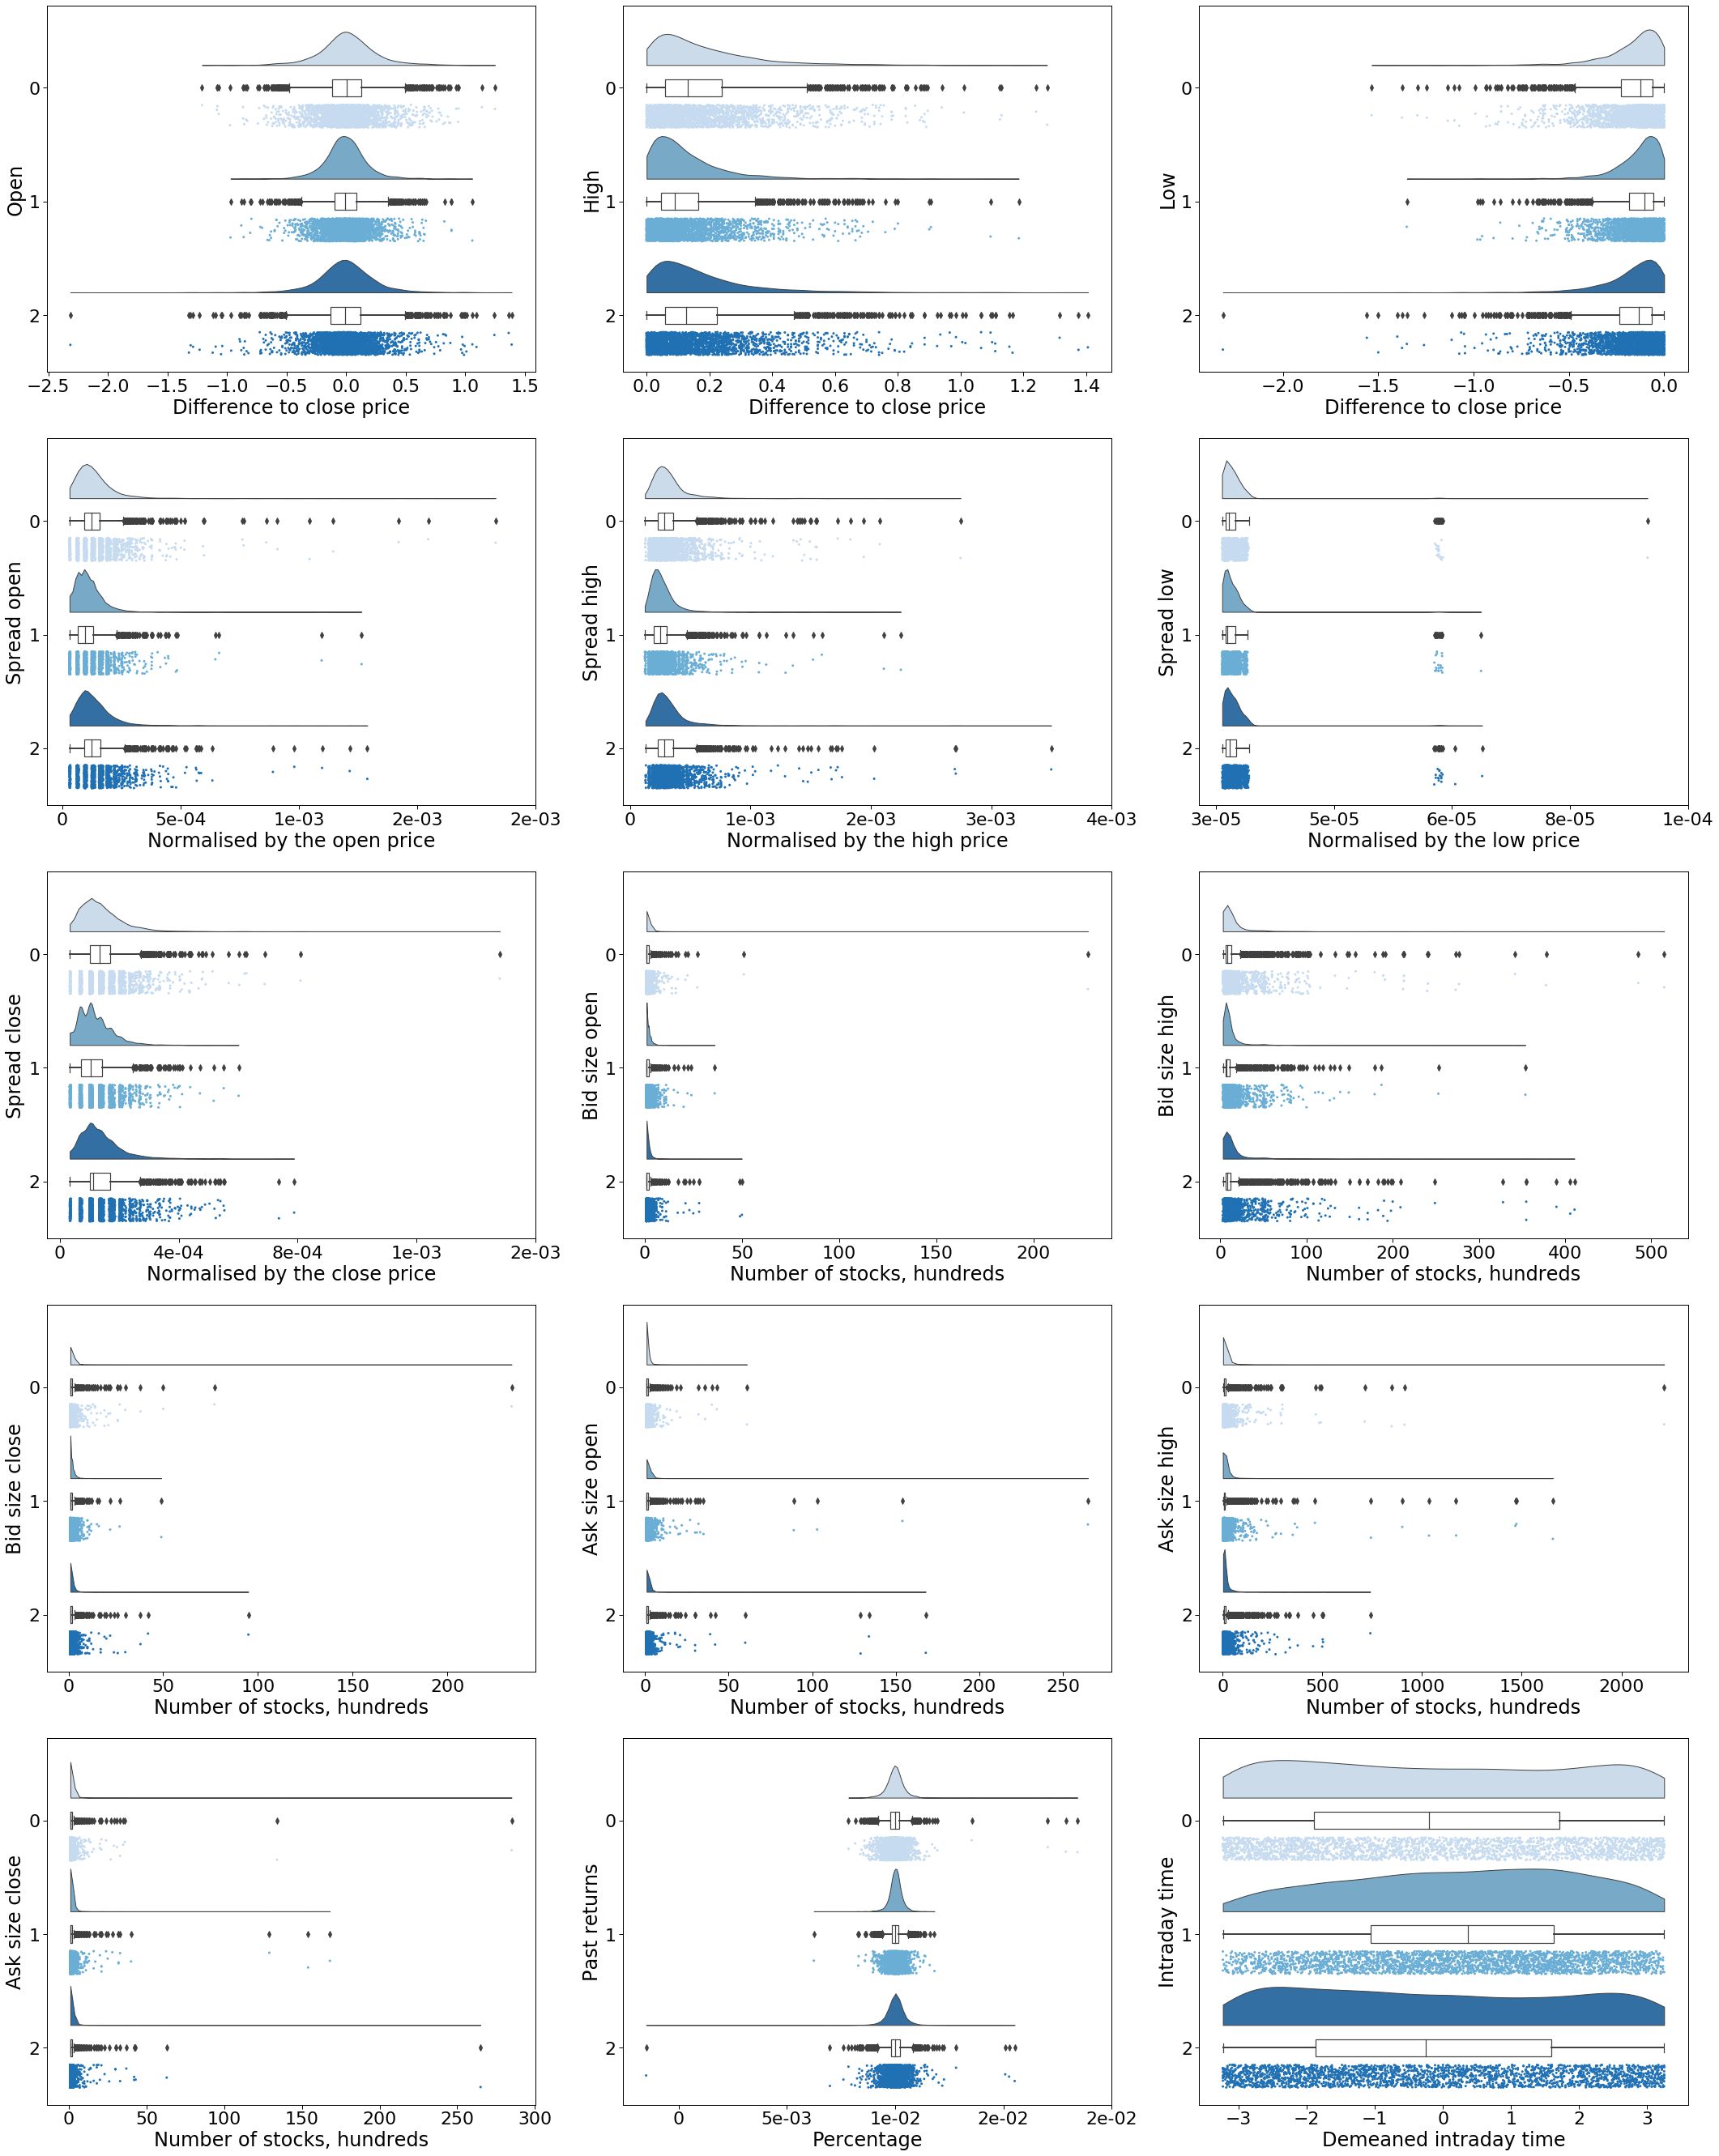

Visualisation of sector

['relReturns_IDU', 'relReturns_IYC', 'relReturns_IYE', 'relReturns_IYG', 'relReturns_IYH', 'relReturns_IYJ', 'relReturns_IYK', 'relReturns_IYM', 'relReturns_IYR', 'relReturns_IYW', 'relReturns_IYZ']


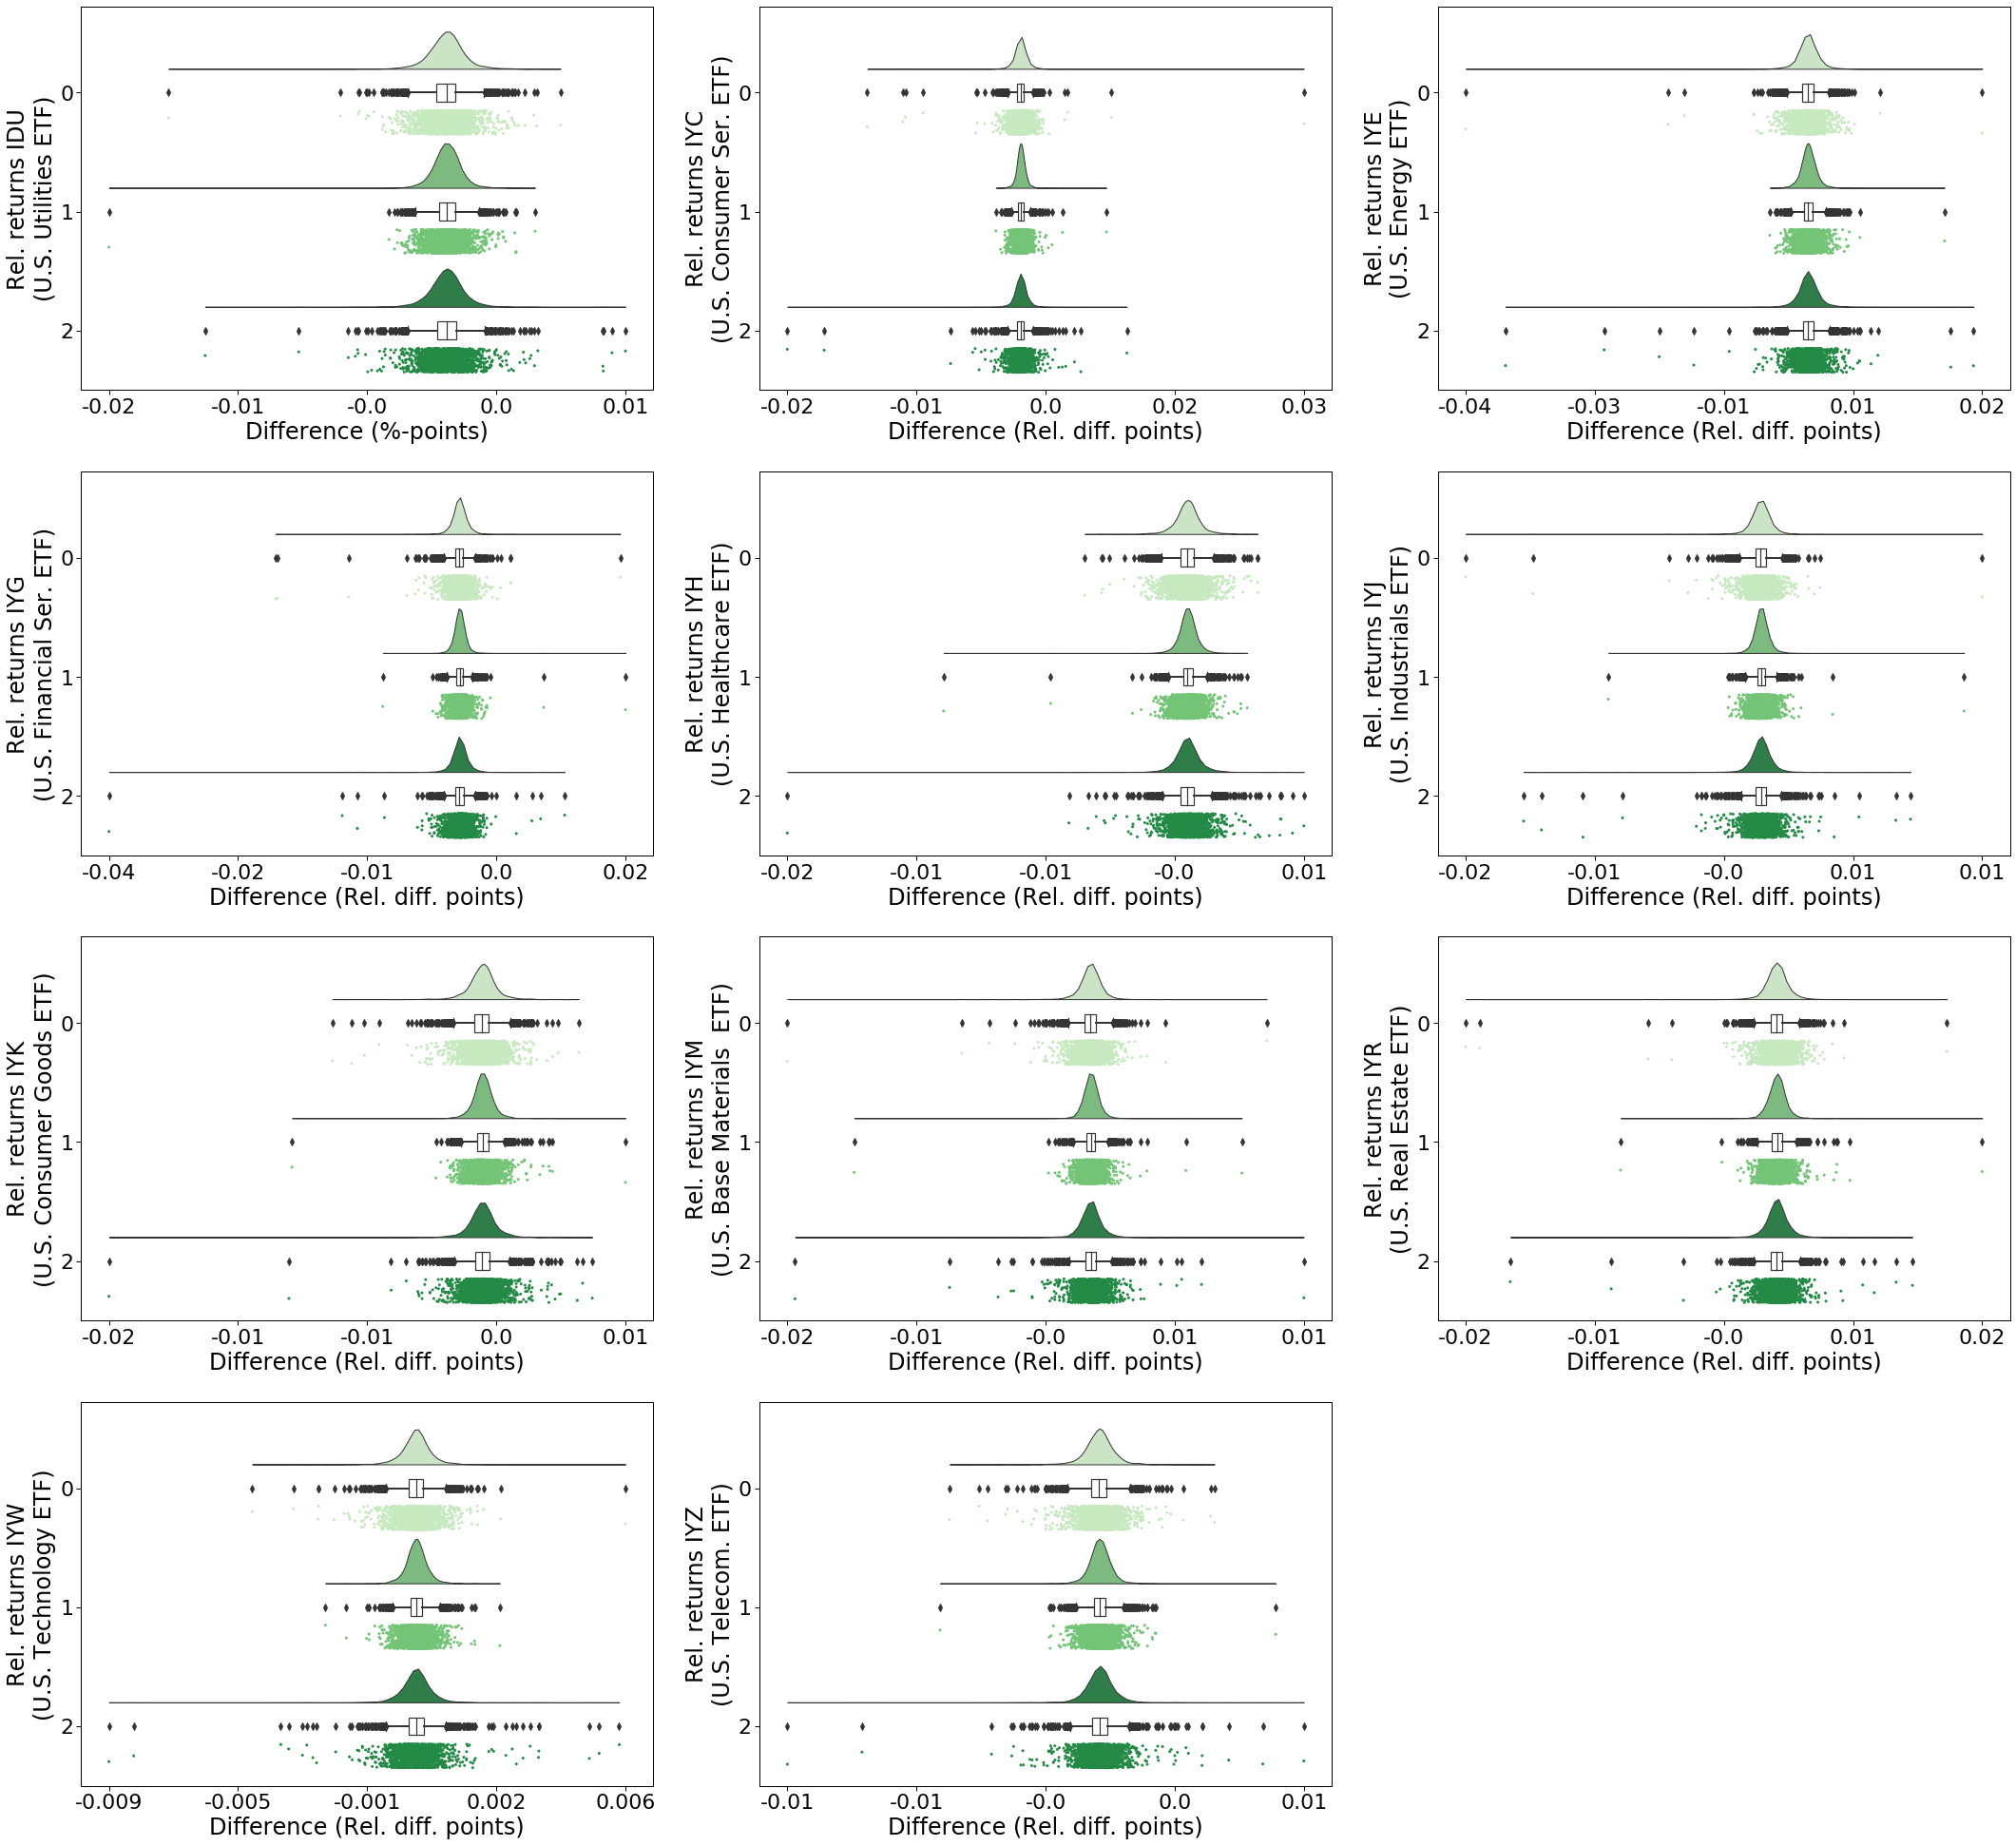

Visualisation of technical

['sma', 'ema', 'stok', 'stod', 'roc', 'rsi', 'atr', 'cci', 'dpo', 'macd', 'macd_diff', 'macd_signal', 'dis5', 'dis10']


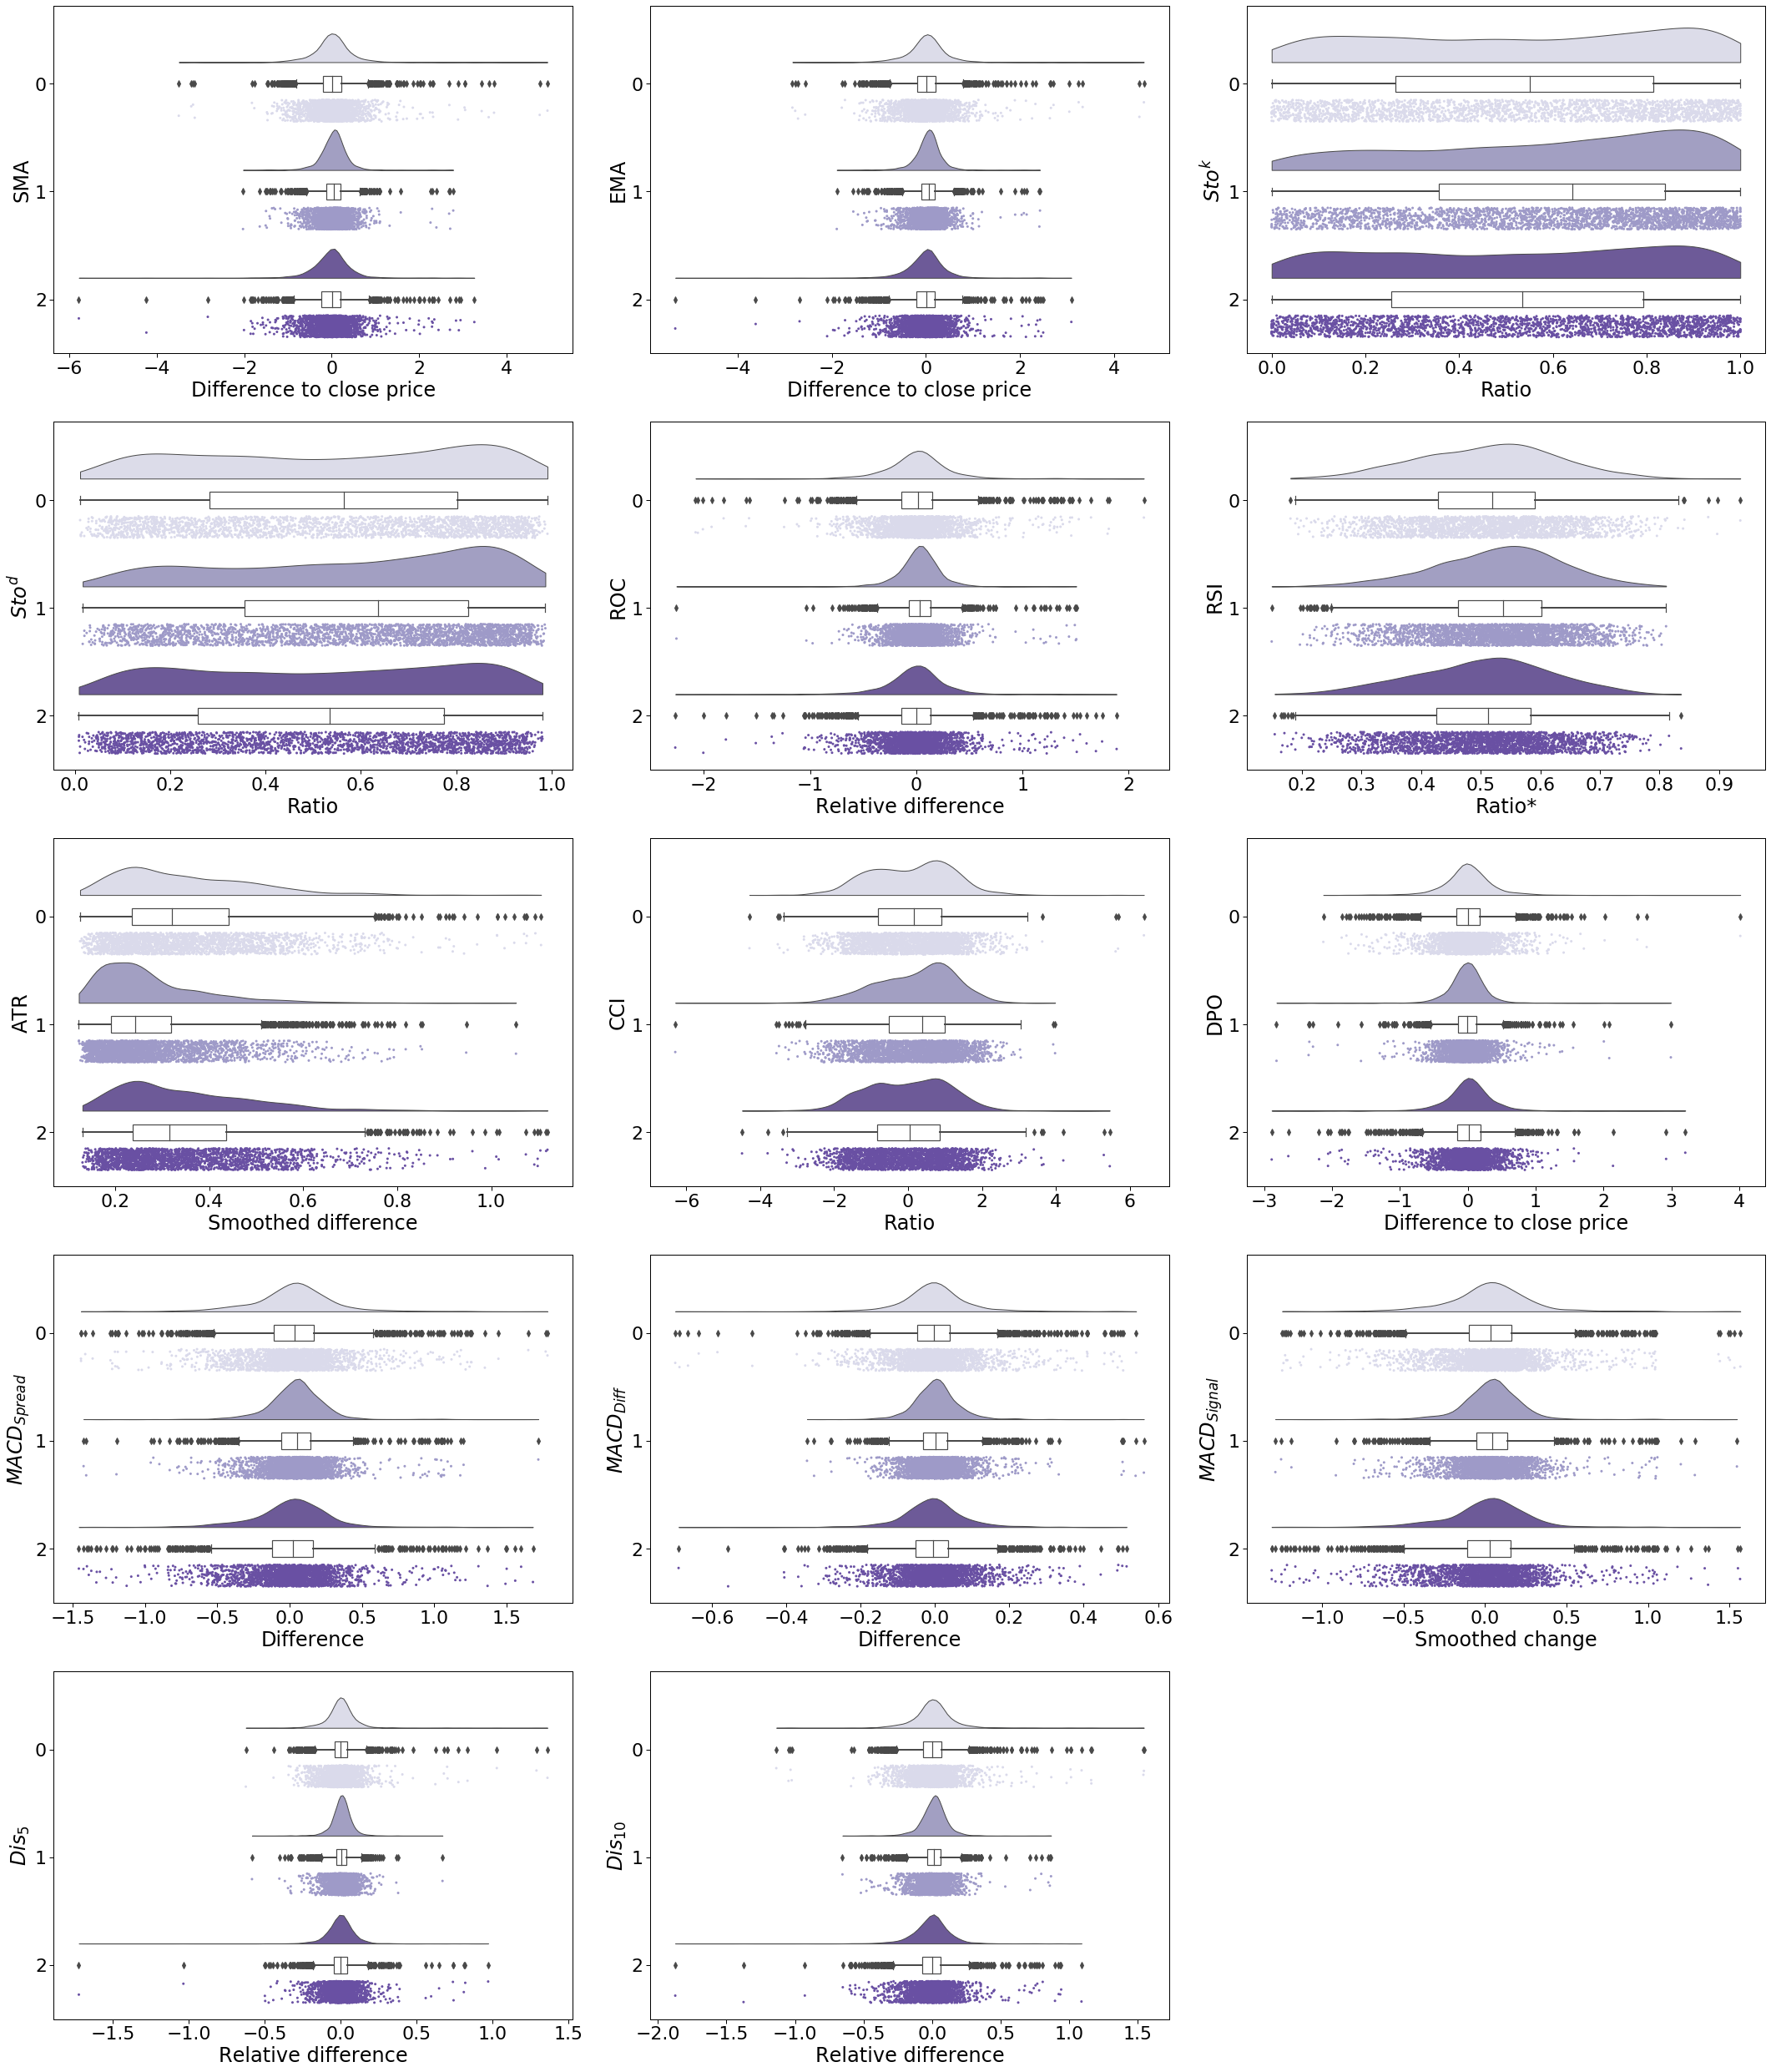

In [70]:
save_plots = False
save_path = '../../../Google Drev/Thesis/Figures/variables'#'../../Figures_Thesis/model_params'
save_date = '20201224'
add_on_name = 'Conditional_test'#3_cols_full_data

conditional = True

cols = 3

plot_full_data = False
ticker_of_interest = 'AAPL'

if plot_full_data:
    ticker_to_plot = reduced_data.copy(deep=True)
else:
    ticker_to_plot = reduced_data[reduced_data.ticker==ticker_of_interest].copy(deep=True)

if conditional:
    sns.set_context("paper", font_scale=2.5)
else:
    sns.set_context("paper", font_scale=2)
    
for var_set in variable_sets:
    if var_set == 'base':
        vs = {'open':'Difference to close price',
                          'high':'Difference to close price',
                          'low':'Difference to close price',
                          'spread_open': 'Normalised by the open price',
                          'spread_high': 'Normalised by the high price',
                          'spread_low': 'Normalised by the low price',
                          'spread_close': 'Normalised by the close price',
                          'bidsize_open': 'Number of stocks, hundreds',
                          'bidsize_high': 'Number of stocks, hundreds',
#                           'bidsize_low': 'Number of stocks, hundreds',
                          'bidsize_close': 'Number of stocks, hundreds',
                          'ofrsize_open': 'Number of stocks, hundreds',
                          'ofrsize_high':'Number of stocks, hundreds',
#                           'ofrsize_low':'Number of stocks, hundreds',
                          'ofrsize_close':'Number of stocks, hundreds',
                          'pastreturns': 'Percentage',
                          'intradaytime':'Demeaned intraday time'}
    elif var_set == 'sector':
#         vs = {'relReturns_IDU':'Relative return to U.S. Utilities sector ETF',
#                             'relReturns_IYC':'Relative return to U.S. Consumer Service sector ETF',
#                             'relReturns_IYE':'Relative return to U.S. Energy sector ETF',
#                             'relReturns_IYG':'Relative return to U.S. Financial Services sector ETF',
#                             'relReturns_IYH':'Relative return to U.S. Healthcare sector ETF',
#                             'relReturns_IYJ':'Relative return to U.S. Industrials sector ETF',
#                             'relReturns_IYK':'Relative return to U.S. Consumer Goods sector ETF',
#                             'relReturns_IYM':'Relative return to U.S. Base Materials sector ETF', 
#                             'relReturns_IYR':'Relative return to U.S. Real Estate sector ETF',
#                             'relReturns_IYW':'Relative return to U.S. Technology sector ETF',
#                             'relReturns_IYZ':'Relative return to U.S. Telecommunications sector ETF'}
        vs = {'relReturns_IDU':'Difference (%-points)',
                            'relReturns_IYC':'Difference (Rel. diff. points)',
                            'relReturns_IYE':'Difference (Rel. diff. points)',
                            'relReturns_IYG':'Difference (Rel. diff. points)',
                            'relReturns_IYH':'Difference (Rel. diff. points)',
                            'relReturns_IYJ':'Difference (Rel. diff. points)',
                            'relReturns_IYK':'Difference (Rel. diff. points)',
                            'relReturns_IYM':'Difference (Rel. diff. points)', 
                            'relReturns_IYR':'Difference (Rel. diff. points)',
                            'relReturns_IYW':'Difference (Rel. diff. points)',
                            'relReturns_IYZ':'Difference (Rel. diff. points)'}
        add_on = {'relReturns_IDU':'(U.S. Utilities ETF)',
                            'relReturns_IYC':'(U.S. Consumer Ser. ETF)',
                            'relReturns_IYE':'(U.S. Energy ETF)',
                            'relReturns_IYG':'(U.S. Financial Ser. ETF)',
                            'relReturns_IYH':'(U.S. Healthcare ETF)',
                            'relReturns_IYJ':'(U.S. Industrials ETF)',
                            'relReturns_IYK':'(U.S. Consumer Goods ETF)',
                            'relReturns_IYM':'(U.S. Base Materials  ETF)', 
                            'relReturns_IYR':'(U.S. Real Estate ETF)',
                            'relReturns_IYW':'(U.S. Technology ETF)',
                            'relReturns_IYZ':'(U.S. Telecom. ETF)'}
    else:
        vs = {'sma':'Difference to close price', 
                               'ema':'Difference to close price',
                               'stok':'Ratio', 
                               'stod':'Ratio', 
                               'roc':'Relative difference',
                               'rsi':'Ratio*', 
                               'atr':'Smoothed difference', 
                               'cci':'Ratio', 
                               'dpo':'Difference to close price', 
                               'macd': 'Difference', 
                               'macd_diff':'Difference',
                               'macd_signal':'Smoothed change', 
                               'dis5':'Relative difference', 
                               'dis10':'Relative difference'}
        
    print('Visualisation of '+var_set+'\n')

    numb_of_vars = len(list(vs.keys()))
    
    if conditional:
        fig, axes = plt.subplots(int(np.ceil(numb_of_vars/cols)),
                                 cols,
                                 figsize=(30,numb_of_vars*2.5))
    else:
        fig, axes = plt.subplots(int(np.ceil(numb_of_vars/cols)),
                                 cols,
                                 figsize=(25,numb_of_vars*2))
        

    columns = list(vs.keys())
    
    print(columns)
    

    for i,j in enumerate(np.arange(0,numb_of_vars,cols)):
        
        for l in np.arange(cols):
            try:
                
                if conditional:
                    pt.RainCloud(x = 'PC',
                                 y = columns[j+l],
                                 data = ticker_to_plot,
                                 bw = 0.2,
                                 width_viol = 0.75,
                                 orient = 'h',
                                 ax=axes[i,l],
                                 palette=colors[var_set],
                                 move=0.25)
                else:
                    pt.RainCloud(y = columns[j+l],
                                 data = ticker_to_plot,
                                 bw = 0.2,
                                 width_viol = 1,
                                 orient = 'h',
                                 ax=axes[i,l],
                                 palette=colors[var_set],
                                 move=0.25)

                ## Set labels
        #         axes[i,0].set_ylabel(columns[j].capitalize().replace('_',' '))
                if var_set == 'sector':
                    varname = columns[j+l].capitalize().replace('_',' ')
                    varname = varname[0:3]+'. '+varname[3:-3]+varname[-3:].upper()+'\n'+add_on[columns[j+l]]
                elif var_set == 'technical':
                    if columns[j+l] in ['EMA','SMA']:
                        varname = 'P'+columns[j+l][0:2].upper()
                    
                    elif len(columns[j+l]) == 3:
                        varname = columns[j+l].upper()
                        
                    elif columns[j+l] in ['stok','stod']:
                        varname = '$'+columns[j+l][0:3].capitalize()+'^{%s}$'%columns[j+l][-1]
                    elif columns[j+l] in ['dis5','dis10']:
                        varname = '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-1] if len(columns[j+l])==4 else '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-2:]
                    elif 'macd' in columns[j+l]:
                        split = re.split('_',columns[j+l])
#                         varname = split[0].upper()+' '+split[-1] if len(columns[j+l])>4 else columns[j+l].upper()
                        varname = '$'+split[0].upper()+'_{%s}$'%split[-1].capitalize() if len(columns[j+l])>4 else '$'+columns[j+l].upper()+'_{%s}$'%'Spread'
                elif 'ofrsize' in columns[j+l]:
                    varname = 'Ask size '+re.split('_',columns[j+l])[-1]
                elif 'bidsize' in columns[j+l]:
                    varname = 'Bid size '+re.split('_',columns[j+l])[-1]
                elif 'intradaytime' == columns[j+l]:
                    varname = 'Intraday time'
                elif 'pastreturns' == columns[j+l]:
                    varname = 'Past returns'
                else:
                    varname = columns[j+l].capitalize().replace('_',' ')

                axes[i,l].set_ylabel(varname)
                axes[i,l].set_xlabel(vs[columns[j+l]])
                
#                 axes[i,l].set_yticks([])
                
                ### Can be used to made prettier x-ticks, but it needs some work to look really good.
#                 axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
#                                                      ticker_to_plot.loc[:,columns[j+l]].max(),5))
#                 axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
#                                                      ticker_to_plot.loc[:,columns[j+l]].max(),5).round(3))
                
                ## Adjust x-axis.

                pos = axes[i,l].get_xticks()
                if (columns[j+l] == 'spread_low'):
                    axes[i,l].set_xticks(np.linspace(pos[1],pos[-1],5))#lambda x: '%.0e' % Decimal(x)
                    pos = axes[i,l].get_xticks()
                    axes[i,l].set_xticklabels(list(map(lambda x: '%.0e' % Decimal(x),np.linspace(pos[0],pos[-1],5))))
                    
                elif columns[j+l] in ['spread_close','spread_high','spread_open','pastreturns']:#(columns[j+l] == 'spread_close')|(columns[j+l] == 'spread_high')|(columns[j+l] == 'spread_open'):
                    
                    axes[i,l].set_xticks(np.linspace(pos[1],pos[-1],5))
                    pos = axes[i,l].get_xticks()
                    axes[i,l].set_xticklabels(['0']+list(map(lambda x: '%.0e' % Decimal(x),np.linspace(0,pos[-1],5)))[1:])

                elif var_set == 'sector':#elif 'IYW' in columns[j+l]:
                    if abs(ticker_to_plot.loc[:,columns[j+l]].min()) < 0.01:
                        axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                         ticker_to_plot.loc[:,columns[j+l]].max(),5))
                        axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                             ticker_to_plot.loc[:,columns[j+l]].max(),5).round(3))
                    else:
                        axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                         ticker_to_plot.loc[:,columns[j+l]].max(),5))
                        axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                             ticker_to_plot.loc[:,columns[j+l]].max(),5).round(2))
                else:
                    None
            
            except:
                axes[i,l].set_visible(False)
    
    if save_plots:
        plt.savefig(save_path+'/'+var_set+'_'+add_on_name+'_'+save_date+'.png', bbox_inches = 'tight')
    else:
        plt.tight_layout()
        plt.show()

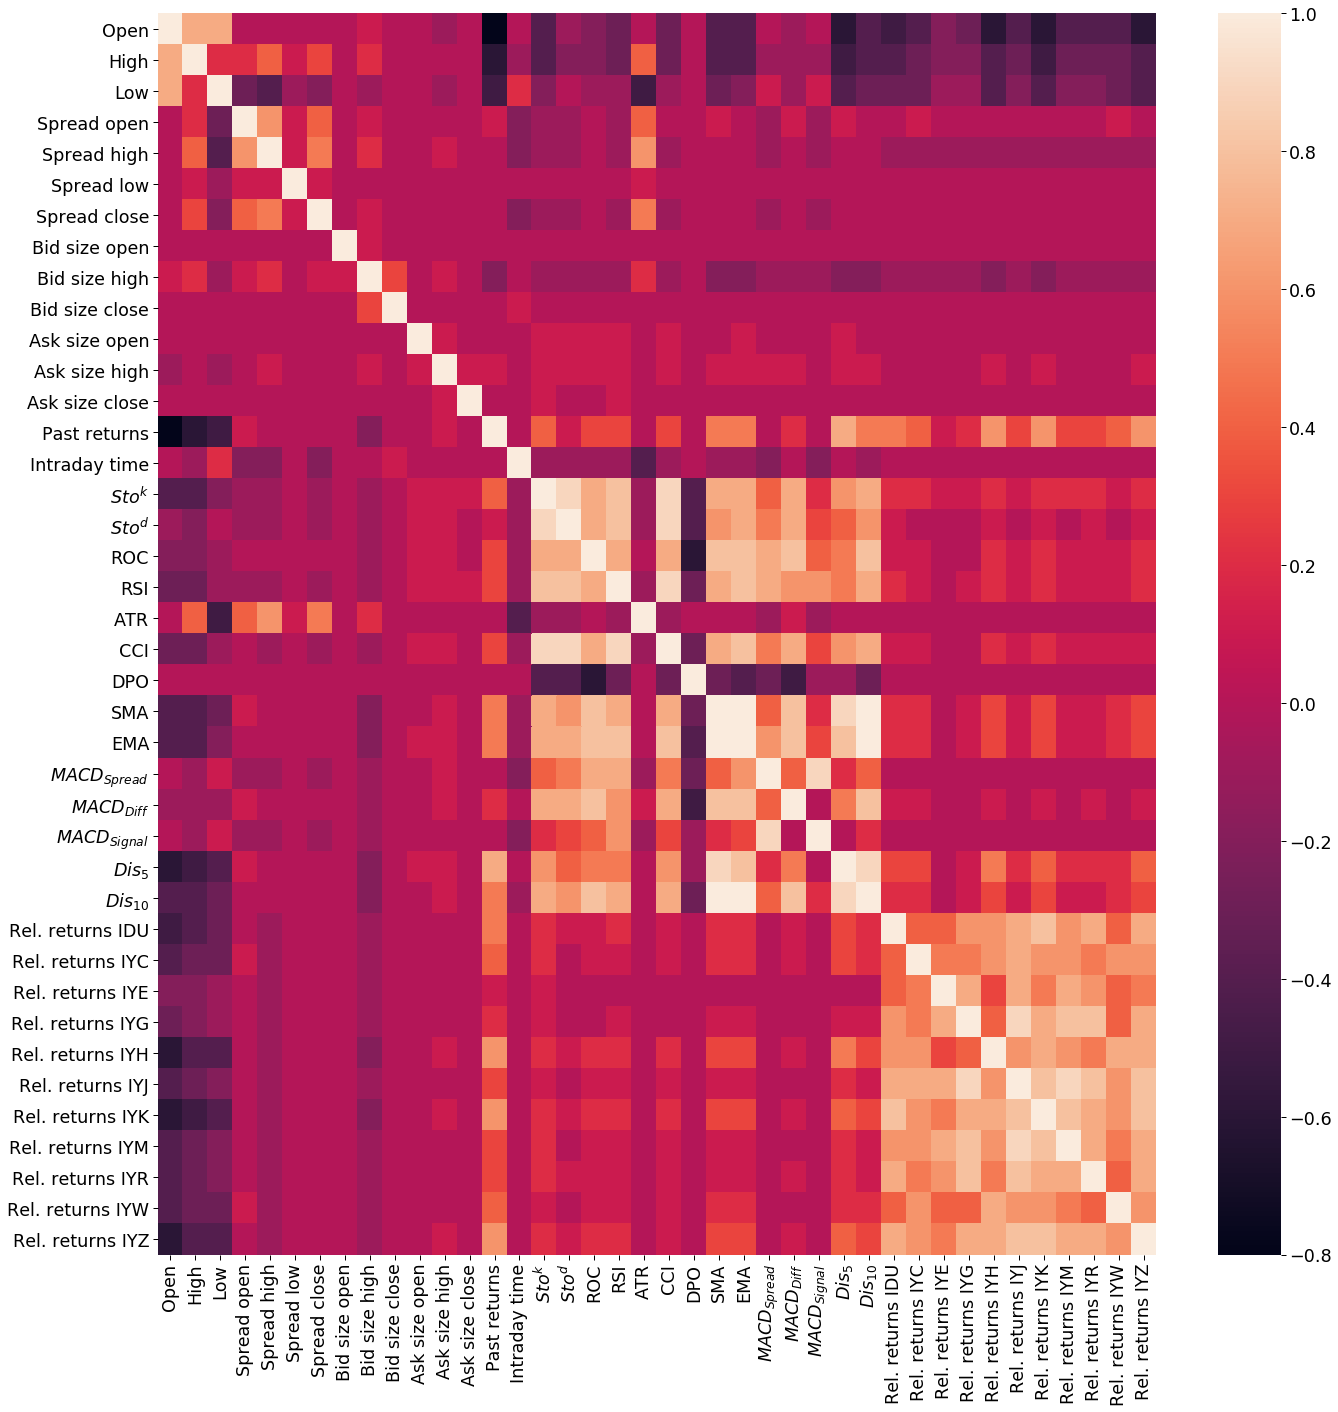

In [82]:
sns.set_context("paper", font_scale=2)

save_plots = True
save_path = '../../../Google Drev/Thesis/Figures/variables'#'../../Figures_Thesis/model_params'
save_date = '20201224'
plot_name = 'heatmap_exo_var'
annotate = False

cols_to_include = [i for i in ticker_to_plot.columns if i not in ['ofrsize_low','bidsize_low','ticker','PC']]
plt.figure(figsize=(20,20))

data_to_heat = ticker_to_plot.loc[:,cols_to_include].copy(deep=True)

new_indices = []
for i in data_to_heat.columns:
    if 'relReturns' in i:
        varname = i.capitalize().replace('_',' ')
        new_indices.append(varname[0:3]+'. '+varname[3:-3]+varname[-3:].upper())#+'\n'+add_on[i])
#     elif var_set == 'technical':
    elif i in ['EMA','SMA']:
        new_indices.append('P'+i[0:2].upper())

    elif (len(i) == 3)&(i!='low'):
        new_indices.append(i.upper())

    elif i in ['stok','stod']:
        new_indices.append('$'+i[0:3].capitalize()+'^{%s}$'%i[-1])
    elif i in ['dis5','dis10']:
        new_indices.append('$'+i[0:3].capitalize()+'_{%s}$'%i[-1] if len(i)==4 else '$'+i[0:3].capitalize()+'_{%s}$'%i[-2:])
    elif 'macd' in i:
        split = re.split('_',i)
        new_indices.append('$'+split[0].upper()+'_{%s}$'%split[-1].capitalize() if len(i)>4 else '$'+i.upper()+'_{%s}$'%'Spread')
    elif 'ofrsize' in i:
        new_indices.append('Ask size '+re.split('_',i)[-1])
    elif 'bidsize' in i:
        new_indices.append('Bid size '+re.split('_',i)[-1])
    elif 'intradaytime' == i:
        new_indices.append('Intraday time')
    elif 'pastreturns' == i:
        new_indices.append('Past returns')
    else:
        new_indices.append(i.capitalize().replace('_',' '))
    
data_to_heat.columns = new_indices

sns.heatmap(data_to_heat.corr().round(1),annot=annotate)

if save_plots:
    plt.tight_layout()
    if annotate:
        plt.savefig(save_path+'/'+plot_name+'_annotated_'+save_date+'.png', bbox_inches = 'tight')
    else:
        plt.savefig(save_path+'/'+plot_name+'_'+save_date+'.png', bbox_inches = 'tight')
else:
    plt.tight_layout()
    plt.show()

In [29]:
int(np.ceil(17/9))

2

In [39]:
def plot_relationship(df=None,
                      pre_process = False,
                      saveplot=False,
                      savedate='1900-01-01',
                      add_name='Remember to specify input',
                      new_folder=True,
                      nf_name = 'New folder',
                      cols_of_plot=3,
                      plot_full_df=False,
                      stock_to_plot=None,
                      conditional_on_pc=False,
                      include_heat=False,
                      heat_plot_name='Specify'):
    
    ################################################# Plots rainclouds ################################################
    ###################################################################################################################
    
    colors = {'base':'Blues','sector':'Greens','technical':'Purples'}
    variable_sets = ['base','sector','technical']
    
    save_plots = saveplot#False
    save_path = '../../../Google Drev/Thesis/Figures/variables'#'../../Figures_Thesis/model_params'
    
    if (new_folder)&(saveplot):
        if not os.path.exists(save_path+'/'+nf_name):
            os.makedirs(save_path+'/'+nf_name)
    
    save_date = savedate#'20201224'
    add_on_name = add_name#'Conditional_test'#3_cols_full_data

    conditional = conditional_on_pc#True

    cols = cols_of_plot#3

    plot_full_data = plot_full_df#False
    ticker_of_interest = stock_to_plot#'AAPL'
    
    if plot_full_data:
        ticker_to_plot = df.copy(deep=True)
    else:
        if pre_process:
            ticker_to_plot = df[df.loc[:,'d_ticker_'+stock_to_plot]==1].copy(deep=True)
        else:
            ticker_to_plot = df[df.ticker==ticker_of_interest].copy(deep=True)
            
    ## Ensure no dummies are included
    dummy_cols = [col for col in df.columns if (col.startswith('d_',0,2) | (any([i in col for i in ['DIA','SPY','QQQ']])))]
    df = df.loc[:,[col for col in df.columns if col not in dummy_cols]]

    if conditional:
        sns.set_context("paper", font_scale=2.5)
    else:
        sns.set_context("paper", font_scale=2)

    for var_set in variable_sets:
        if var_set == 'base':
            vs = {'open':'Difference to close price',
                              'high':'Difference to close price',
                              'low':'Difference to close price',
                              'spread_open': 'Normalised by the open price',
                              'spread_high': 'Normalised by the high price',
                              'spread_low': 'Normalised by the low price',
                              'spread_close': 'Normalised by the close price',
                              'bidsize_open': 'Number of stocks, hundreds',
                              'bidsize_high': 'Number of stocks, hundreds',
    #                           'bidsize_low': 'Number of stocks, hundreds',
                              'bidsize_close': 'Number of stocks, hundreds',
                              'ofrsize_open': 'Number of stocks, hundreds',
                              'ofrsize_high':'Number of stocks, hundreds',
    #                           'ofrsize_low':'Number of stocks, hundreds',
                              'ofrsize_close':'Number of stocks, hundreds',
                              'pastreturns': 'Percentage',
                              'intradaytime':'Demeaned intraday time'}
        elif var_set == 'sector':

            vs = {'relReturns_IDU':'Difference (%-points)',
                                'relReturns_IYC':'Difference (Rel. diff. points)',
                                'relReturns_IYE':'Difference (Rel. diff. points)',
                                'relReturns_IYG':'Difference (Rel. diff. points)',
                                'relReturns_IYH':'Difference (Rel. diff. points)',
                                'relReturns_IYJ':'Difference (Rel. diff. points)',
                                'relReturns_IYK':'Difference (Rel. diff. points)',
                                'relReturns_IYM':'Difference (Rel. diff. points)', 
                                'relReturns_IYR':'Difference (Rel. diff. points)',
                                'relReturns_IYW':'Difference (Rel. diff. points)',
                                'relReturns_IYZ':'Difference (Rel. diff. points)'}
            add_on = {'relReturns_IDU':'(U.S. Utilities ETF)',
                                'relReturns_IYC':'(U.S. Consumer Ser. ETF)',
                                'relReturns_IYE':'(U.S. Energy ETF)',
                                'relReturns_IYG':'(U.S. Financial Ser. ETF)',
                                'relReturns_IYH':'(U.S. Healthcare ETF)',
                                'relReturns_IYJ':'(U.S. Industrials ETF)',
                                'relReturns_IYK':'(U.S. Consumer Goods ETF)',
                                'relReturns_IYM':'(U.S. Base Materials  ETF)', 
                                'relReturns_IYR':'(U.S. Real Estate ETF)',
                                'relReturns_IYW':'(U.S. Technology ETF)',
                                'relReturns_IYZ':'(U.S. Telecom. ETF)'}
        else:
            vs = {'sma':'Difference to close price', 
                                   'ema':'Difference to close price',
                                   'stok':'Ratio', 
                                   'stod':'Ratio', 
                                   'roc':'Relative difference',
                                   'rsi':'Ratio*', 
                                   'atr':'Smoothed difference', 
                                   'cci':'Ratio', 
                                   'dpo':'Difference to close price', 
                                   'macd': 'Difference', 
                                   'macd_diff':'Difference',
                                   'macd_signal':'Smoothed change', 
                                   'dis5':'Relative difference', 
                                   'dis10':'Relative difference'}

        print('Visualisation of '+var_set+'\n')

        numb_of_vars = len(list(vs.keys()))

        if conditional:
            fig, axes = plt.subplots(int(np.ceil(numb_of_vars/cols)),
                                     cols,
                                     figsize=(30,numb_of_vars*2.5))
        else:
            fig, axes = plt.subplots(int(np.ceil(numb_of_vars/cols)),
                                     cols,
                                     figsize=(25,numb_of_vars*2))


        columns = list(vs.keys())

        print(columns)


        for i,j in enumerate(np.arange(0,numb_of_vars,cols)):

            for l in np.arange(cols):
                try:

                    if conditional:
                        pt.RainCloud(x = 'PC',
                                     y = columns[j+l],
                                     data = ticker_to_plot,
                                     bw = 0.2,
                                     width_viol = 0.75,
                                     orient = 'h',
                                     ax=axes[i,l],
                                     palette=colors[var_set],
                                     move=0.25)
                    else:
                        pt.RainCloud(y = columns[j+l],
                                     data = ticker_to_plot,
                                     bw = 0.2,
                                     width_viol = 1,
                                     orient = 'h',
                                     ax=axes[i,l],
                                     palette=colors[var_set],
                                     move=0.25)

                    ## Set labels
                    if var_set == 'sector':
                        varname = columns[j+l].capitalize().replace('_',' ')
                        varname = varname[0:3]+'. '+varname[3:-3]+varname[-3:].upper()+'\n'+add_on[columns[j+l]]
                    elif var_set == 'technical':
                        if columns[j+l] in ['EMA','SMA']:
                            varname = 'P'+columns[j+l][0:2].upper()

                        elif len(columns[j+l]) == 3:
                            varname = columns[j+l].upper()

                        elif columns[j+l] in ['stok','stod']:
                            varname = '$'+columns[j+l][0:3].capitalize()+'^{%s}$'%columns[j+l][-1]
                        elif columns[j+l] in ['dis5','dis10']:
                            varname = '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-1] if len(columns[j+l])==4 else '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-2:]
                        elif 'macd' in columns[j+l]:
                            split = re.split('_',columns[j+l])
                            varname = '$'+split[0].upper()+'_{%s}$'%split[-1].capitalize() if len(columns[j+l])>4 else '$'+columns[j+l].upper()+'_{%s}$'%'Spread'
                    elif 'ofrsize' in columns[j+l]:
                        varname = 'Ask size '+re.split('_',columns[j+l])[-1]
                    elif 'bidsize' in columns[j+l]:
                        varname = 'Bid size '+re.split('_',columns[j+l])[-1]
                    elif 'intradaytime' == columns[j+l]:
                        varname = 'Intraday time'
                    elif 'pastreturns' == columns[j+l]:
                        varname = 'Past returns'
                    else:
                        varname = columns[j+l].capitalize().replace('_',' ')

                    axes[i,l].set_ylabel(varname)
                    axes[i,l].set_xlabel(vs[columns[j+l]])

                    ## Adjust x-axis.

                    pos = axes[i,l].get_xticks()
                    if (columns[j+l] == 'spread_low'):
                        axes[i,l].set_xticks(np.linspace(pos[1],pos[-1],5))
                        pos = axes[i,l].get_xticks()
                        axes[i,l].set_xticklabels(list(map(lambda x: '%.0e' % Decimal(x),np.linspace(pos[0],pos[-1],5))))

                    elif columns[j+l] in ['spread_close','spread_high','spread_open','pastreturns']:#(columns[j+l] == 'spread_close')|(columns[j+l] == 'spread_high')|(columns[j+l] == 'spread_open'):

                        axes[i,l].set_xticks(np.linspace(pos[1],pos[-1],5))
                        pos = axes[i,l].get_xticks()
                        axes[i,l].set_xticklabels(['0']+list(map(lambda x: '%.0e' % Decimal(x),np.linspace(0,pos[-1],5)))[1:])

                    elif var_set == 'sector':#elif 'IYW' in columns[j+l]:
                        if abs(ticker_to_plot.loc[:,columns[j+l]].min()) < 0.01:
                            axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                             ticker_to_plot.loc[:,columns[j+l]].max(),5))
                            axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                 ticker_to_plot.loc[:,columns[j+l]].max(),5).round(3))
                        else:
                            axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                             ticker_to_plot.loc[:,columns[j+l]].max(),5))
                            axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                 ticker_to_plot.loc[:,columns[j+l]].max(),5).round(2))
                    else:
                        None

                except:
                    axes[i,l].set_visible(False)

        if save_plots:
            if new_folder:
                
                plt.savefig(save_path+'/'+nf_name+'/'+var_set+'_'+add_on_name+'_'+save_date+'.png', bbox_inches = 'tight')
                plt.close(fig)
            else:
                
                plt.savefig(save_path+'/'+var_set+'_'+add_on_name+'_'+save_date+'.png', bbox_inches = 'tight')
                plt.close(fig)
        else:
            plt.tight_layout()
            plt.show()
            
            
    if include_heat:
        
        sns.set_context("paper", font_scale=2)

        save_plots = saveplot#True
        save_path = '../../../Google Drev/Thesis/Figures/variables'#'../../Figures_Thesis/model_params'
        save_date = savedate#'20201224'
        plot_name = heat_plot_name#'heatmap_exo_var'
        annotate = False

        cols_to_include = [i for i in df.columns if i not in ['ofrsize_low','bidsize_low','ticker','PC']]
        fig = plt.figure(figsize=(20,20))

        data_to_heat = df.loc[:,cols_to_include].copy(deep=True)

        new_indices = []
        for i in data_to_heat.columns:
            if 'relReturns' in i:
                varname = i.capitalize().replace('_',' ')
                new_indices.append(varname[0:3]+'. '+varname[3:-3]+varname[-3:].upper())#+'\n'+add_on[i])
        #     elif var_set == 'technical':
            elif i in ['EMA','SMA']:
                new_indices.append('P'+i[0:2].upper())

            elif (len(i) == 3)&(i!='low'):
                new_indices.append(i.upper())

            elif i in ['stok','stod']:
                new_indices.append('$'+i[0:3].capitalize()+'^{%s}$'%i[-1])
            elif i in ['dis5','dis10']:
                new_indices.append('$'+i[0:3].capitalize()+'_{%s}$'%i[-1] if len(i)==4 else '$'+i[0:3].capitalize()+'_{%s}$'%i[-2:])
            elif 'macd' in i:
                split = re.split('_',i)
                new_indices.append('$'+split[0].upper()+'_{%s}$'%split[-1].capitalize() if len(i)>4 else '$'+i.upper()+'_{%s}$'%'Spread')
            elif 'ofrsize' in i:
                new_indices.append('Ask size '+re.split('_',i)[-1])
            elif 'bidsize' in i:
                new_indices.append('Bid size '+re.split('_',i)[-1])
            elif 'intradaytime' == i:
                new_indices.append('Intraday time')
            elif 'pastreturns' == i:
                new_indices.append('Past returns')
            else:
                new_indices.append(i.capitalize().replace('_',' '))

        data_to_heat.columns = new_indices

        sns.heatmap(data_to_heat.corr().round(1),annot=annotate)

        if save_plots:
            plt.tight_layout()
#             if annotate:
#                 plt.savefig(save_path+'/'+plot_name+'_annotated_'+save_date+'.png', bbox_inches = 'tight')
#             else:
#                 plt.savefig(save_path+'/'+plot_name+'_'+save_date+'.png', bbox_inches = 'tight')
            if new_folder:
                plt.savefig(save_path+'/'+nf_name+'/'+heat_plot_name+'_'+save_date+'.png', bbox_inches = 'tight')
                plt.close(fig)
            else:
                plt.savefig(save_path+'/'+heat_plot_name+'_'+save_date+'.png', bbox_inches = 'tight')
                plt.close(fig)
        else:
            plt.tight_layout()
            plt.show()
            
def plot_relationship_v2(df=None,
                         pre_process = False,
                         saveplot=False,
                         savedate='1900-01-01',
                         add_name='Remember to specify input',
                         new_folder=True,
                         nf_name = 'New folder',
                         cols_of_plot=3,
                         max_subplots=9,
                         plot_full_df=False,
                         stock_to_plot=None,
                         conditional_plot =False,
                         conditional_on =False,
                         include_heat=False,
                         heat_plot_name='Specify'):
    
    ################################################# Plots rainclouds ################################################
    ###################################################################################################################
    
    colors = {'base':'Blues','sector':'Greens','technical':'Purples'}
    variable_sets = ['base','sector','technical']
    
    save_plots = saveplot#False
    save_path = '../../../Google Drev/Thesis/Figures/variables'#'../../Figures_Thesis/model_params'
    
    if (new_folder)&(saveplot):
        if not os.path.exists(save_path+'/'+nf_name):
            os.makedirs(save_path+'/'+nf_name)
    
    save_date = savedate#'20201224'
    add_on_name = add_name#'Conditional_test'#3_cols_full_data

    conditional = conditional_plot#True

    cols = cols_of_plot#3

    plot_full_data = plot_full_df#False
    ticker_of_interest = stock_to_plot#'AAPL'
    
    if plot_full_data:
        ticker_to_plot = df.copy(deep=True)
    else:
        if pre_process:
            ticker_to_plot = df[df.loc[:,'d_ticker_'+stock_to_plot]==1].copy(deep=True)
        else:
            ticker_to_plot = df[df.ticker==ticker_of_interest].copy(deep=True)
            
    ## Ensure no dummies are included
    dummy_cols = [col for col in df.columns if (col.startswith('d_',0,2) | (any([i in col for i in ['DIA','SPY','QQQ']])))]
    df = df.loc[:,[col for col in df.columns if col not in dummy_cols]]

    if conditional:
        sns.set_context("paper", font_scale=2.5)
    else:
        sns.set_context("paper", font_scale=2)

    for var_set in variable_sets:
        if var_set == 'base':
            vs = {'open':'Difference to close price',
                              'high':'Difference to close price',
                              'low':'Difference to close price',
                              'spread_open': 'Normalised by the open price',
                              'spread_high': 'Normalised by the high price',
                              'spread_low': 'Normalised by the low price',
                              'spread_close': 'Normalised by the close price',
                              'bidsize_open': 'Number of stocks, hundreds',
                              'bidsize_high': 'Number of stocks, hundreds',
    #                           'bidsize_low': 'Number of stocks, hundreds',
                              'bidsize_close': 'Number of stocks, hundreds',
                              'ofrsize_open': 'Number of stocks, hundreds',
                              'ofrsize_high':'Number of stocks, hundreds',
    #                           'ofrsize_low':'Number of stocks, hundreds',
                              'ofrsize_close':'Number of stocks, hundreds',
                              'pastreturns': 'Percentage',
                              'intradaytime':'Demeaned intraday time'}
        elif var_set == 'sector':

            vs = {'relReturns_IDU':'Difference (%-points)',
                                'relReturns_IYC':'Difference (Rel. diff. points)',
                                'relReturns_IYE':'Difference (Rel. diff. points)',
                                'relReturns_IYG':'Difference (Rel. diff. points)',
                                'relReturns_IYH':'Difference (Rel. diff. points)',
                                'relReturns_IYJ':'Difference (Rel. diff. points)',
                                'relReturns_IYK':'Difference (Rel. diff. points)',
                                'relReturns_IYM':'Difference (Rel. diff. points)', 
                                'relReturns_IYR':'Difference (Rel. diff. points)',
                                'relReturns_IYW':'Difference (Rel. diff. points)',
                                'relReturns_IYZ':'Difference (Rel. diff. points)'}
            add_on = {'relReturns_IDU':'(U.S. Utilities ETF)',
                                'relReturns_IYC':'(U.S. Consumer Ser. ETF)',
                                'relReturns_IYE':'(U.S. Energy ETF)',
                                'relReturns_IYG':'(U.S. Financial Ser. ETF)',
                                'relReturns_IYH':'(U.S. Healthcare ETF)',
                                'relReturns_IYJ':'(U.S. Industrials ETF)',
                                'relReturns_IYK':'(U.S. Consumer Goods ETF)',
                                'relReturns_IYM':'(U.S. Base Materials  ETF)', 
                                'relReturns_IYR':'(U.S. Real Estate ETF)',
                                'relReturns_IYW':'(U.S. Technology ETF)',
                                'relReturns_IYZ':'(U.S. Telecom. ETF)'}
        else:
            vs = {'sma':'Difference to close price', 
                                   'ema':'Difference to close price',
                                   'stok':'Ratio', 
                                   'stod':'Ratio', 
                                   'roc':'Relative difference',
                                   'rsi':'Ratio*', 
                                   'atr':'Smoothed difference', 
                                   'cci':'Ratio', 
                                   'dpo':'Difference to close price', 
                                   'macd': 'Difference', 
                                   'macd_diff':'Difference',
                                   'macd_signal':'Smoothed change', 
                                   'dis5':'Relative difference', 
                                   'dis10':'Relative difference'}

        print('Visualisation of '+var_set+'\n')
#         print('\n',columns)
        
        numb_of_vars = len(list(vs.keys()))
        if numb_of_vars > max_subplots:
            w = 0
            for ps in np.arange(int(np.ceil(numb_of_vars/max_subplots))):
                                
                if conditional:
                    fig, axes = plt.subplots(int(np.ceil(max_subplots/cols)),
                                             cols,
                                             figsize=(30,max_subplots*2.5))
                else:
                    fig, axes = plt.subplots(int(np.ceil(max_subplots/cols)),
                                             cols,
                                             figsize=(25,max_subplots*2))

                columns = list(vs.keys())

                for i,j in enumerate(np.arange(w,w+max_subplots,cols)):

                    for l in np.arange(cols):
                        try:

                            if conditional:
                                pt.RainCloud(x = conditional_on,
                                             y = columns[j+l],
                                             data = ticker_to_plot,
                                             bw = 0.2,
                                             width_viol = 0.75,
                                             orient = 'h',
                                             ax=axes[i,l],
                                             palette=colors[var_set],
                                             move=0.25)
                            else:
                                pt.RainCloud(y = columns[j+l],
                                             data = ticker_to_plot,
                                             bw = 0.2,
                                             width_viol = 1,
                                             orient = 'h',
                                             ax=axes[i,l],
                                             palette=colors[var_set],
                                             move=0.25)

                            ## Set labels
                            if var_set == 'sector':
                                varname = columns[j+l].capitalize().replace('_',' ')
                                varname = varname[0:3]+'. '+varname[3:-3]+varname[-3:].upper()+'\n'+add_on[columns[j+l]]
                            elif var_set == 'technical':
                                if columns[j+l] in ['EMA','SMA']:
                                    varname = 'P'+columns[j+l][0:2].upper()

                                elif len(columns[j+l]) == 3:
                                    varname = columns[j+l].upper()

                                elif columns[j+l] in ['stok','stod']:
                                    varname = '$'+columns[j+l][0:3].capitalize()+'^{%s}$'%columns[j+l][-1]
                                elif columns[j+l] in ['dis5','dis10']:
                                    varname = '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-1] if len(columns[j+l])==4 else '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-2:]
                                elif 'macd' in columns[j+l]:
                                    split = re.split('_',columns[j+l])
                                    varname = '$'+split[0].upper()+'_{%s}$'%split[-1].capitalize() if len(columns[j+l])>4 else '$'+columns[j+l].upper()+'_{%s}$'%'Spread'
                            elif 'ofrsize' in columns[j+l]:
                                varname = 'Ask size '+re.split('_',columns[j+l])[-1]
                            elif 'bidsize' in columns[j+l]:
                                varname = 'Bid size '+re.split('_',columns[j+l])[-1]
                            elif 'intradaytime' == columns[j+l]:
                                varname = 'Intraday time'
                            elif 'pastreturns' == columns[j+l]:
                                varname = 'Past returns'
                            else:
                                varname = columns[j+l].capitalize().replace('_',' ')

                            axes[i,l].set_ylabel(varname)
                            axes[i,l].set_xlabel(vs[columns[j+l]])

                            ## Adjust x-axis.

                            pos = axes[i,l].get_xticks()
                            if (columns[j+l] == 'spread_low'):
                                axes[i,l].set_xticks(np.linspace(pos[1],pos[-1],5))
                                pos = axes[i,l].get_xticks()
                                axes[i,l].set_xticklabels(list(map(lambda x: '%.0e' % Decimal(x),np.linspace(pos[0],pos[-1],5))))

                            elif columns[j+l] in ['spread_close','spread_high','spread_open','pastreturns']:#(columns[j+l] == 'spread_close')|(columns[j+l] == 'spread_high')|(columns[j+l] == 'spread_open'):

                                axes[i,l].set_xticks(np.linspace(pos[1],pos[-1],5))
                                pos = axes[i,l].get_xticks()
                                axes[i,l].set_xticklabels(['0']+list(map(lambda x: '%.0e' % Decimal(x),np.linspace(0,pos[-1],5)))[1:])

                            elif var_set == 'sector':#elif 'IYW' in columns[j+l]:
                                if abs(ticker_to_plot.loc[:,columns[j+l]].min()) < 0.01:
                                    axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                     ticker_to_plot.loc[:,columns[j+l]].max(),5))
                                    axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                         ticker_to_plot.loc[:,columns[j+l]].max(),5).round(3))
                                else:
                                    axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                     ticker_to_plot.loc[:,columns[j+l]].max(),5))
                                    axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                         ticker_to_plot.loc[:,columns[j+l]].max(),5).round(2))
                            else:
                                None

                        except:
                            axes[i,l].set_visible(False)

                if save_plots:
                    if new_folder:

                        plt.savefig(save_path+'/'+nf_name+'/'+var_set+'_'+add_on_name+'_'+str(ps)+'_'+save_date+'.png', bbox_inches = 'tight')
                        plt.close(fig)
                    else:

                        plt.savefig(save_path+'/'+var_set+'_'+add_on_name+'_'+str(ps)+save_date+'.png', bbox_inches = 'tight')
                        plt.close(fig)
                else:
                    plt.tight_layout()
                    plt.show()
                    
                w += max_subplots
                    
        else:

            if conditional:
                fig, axes = plt.subplots(int(np.ceil(numb_of_vars/cols)),
                                         cols,
                                         figsize=(30,numb_of_vars*2.5))
            else:
                fig, axes = plt.subplots(int(np.ceil(numb_of_vars/cols)),
                                         cols,
                                         figsize=(25,numb_of_vars*2))


            columns = list(vs.keys())

    #         print(columns)


            for i,j in enumerate(np.arange(0,numb_of_vars,cols)):

                for l in np.arange(cols):
                    try:

                        if conditional:
                            pt.RainCloud(x = conditional_on,
                                         y = columns[j+l],
                                         data = ticker_to_plot,
                                         bw = 0.2,
                                         width_viol = 0.75,
                                         orient = 'h',
                                         ax=axes[i,l],
                                         palette=colors[var_set],
                                         move=0.25)
                        else:
                            pt.RainCloud(y = columns[j+l],
                                         data = ticker_to_plot,
                                         bw = 0.2,
                                         width_viol = 1,
                                         orient = 'h',
                                         ax=axes[i,l],
                                         palette=colors[var_set],
                                         move=0.25)

                        ## Set labels
                        if var_set == 'sector':
                            varname = columns[j+l].capitalize().replace('_',' ')
                            varname = varname[0:3]+'. '+varname[3:-3]+varname[-3:].upper()+'\n'+add_on[columns[j+l]]
                        elif var_set == 'technical':
                            if columns[j+l] in ['EMA','SMA']:
                                varname = 'P'+columns[j+l][0:2].upper()

                            elif len(columns[j+l]) == 3:
                                varname = columns[j+l].upper()

                            elif columns[j+l] in ['stok','stod']:
                                varname = '$'+columns[j+l][0:3].capitalize()+'^{%s}$'%columns[j+l][-1]
                            elif columns[j+l] in ['dis5','dis10']:
                                varname = '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-1] if len(columns[j+l])==4 else '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-2:]
                            elif 'macd' in columns[j+l]:
                                split = re.split('_',columns[j+l])
                                varname = '$'+split[0].upper()+'_{%s}$'%split[-1].capitalize() if len(columns[j+l])>4 else '$'+columns[j+l].upper()+'_{%s}$'%'Spread'
                        elif 'ofrsize' in columns[j+l]:
                            varname = 'Ask size '+re.split('_',columns[j+l])[-1]
                        elif 'bidsize' in columns[j+l]:
                            varname = 'Bid size '+re.split('_',columns[j+l])[-1]
                        elif 'intradaytime' == columns[j+l]:
                            varname = 'Intraday time'
                        elif 'pastreturns' == columns[j+l]:
                            varname = 'Past returns'
                        else:
                            varname = columns[j+l].capitalize().replace('_',' ')

                        axes[i,l].set_ylabel(varname)
                        axes[i,l].set_xlabel(vs[columns[j+l]])

                        ## Adjust x-axis.

                        pos = axes[i,l].get_xticks()
                        if (columns[j+l] == 'spread_low'):
                            axes[i,l].set_xticks(np.linspace(pos[1],pos[-1],5))
                            pos = axes[i,l].get_xticks()
                            axes[i,l].set_xticklabels(list(map(lambda x: '%.0e' % Decimal(x),np.linspace(pos[0],pos[-1],5))))

                        elif columns[j+l] in ['spread_close','spread_high','spread_open','pastreturns']:#(columns[j+l] == 'spread_close')|(columns[j+l] == 'spread_high')|(columns[j+l] == 'spread_open'):

                            axes[i,l].set_xticks(np.linspace(pos[1],pos[-1],5))
                            pos = axes[i,l].get_xticks()
                            axes[i,l].set_xticklabels(['0']+list(map(lambda x: '%.0e' % Decimal(x),np.linspace(0,pos[-1],5)))[1:])

                        elif var_set == 'sector':#elif 'IYW' in columns[j+l]:
                            if abs(ticker_to_plot.loc[:,columns[j+l]].min()) < 0.01:
                                axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                 ticker_to_plot.loc[:,columns[j+l]].max(),5))
                                axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                     ticker_to_plot.loc[:,columns[j+l]].max(),5).round(3))
                            else:
                                axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                 ticker_to_plot.loc[:,columns[j+l]].max(),5))
                                axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                     ticker_to_plot.loc[:,columns[j+l]].max(),5).round(2))
                        else:
                            None

                    except:
                        axes[i,l].set_visible(False)

            if save_plots:
                if new_folder:

                    plt.savefig(save_path+'/'+nf_name+'/'+var_set+'_'+add_on_name+'_'+save_date+'.png', bbox_inches = 'tight')
                    plt.close(fig)
                else:

                    plt.savefig(save_path+'/'+var_set+'_'+add_on_name+'_'+save_date+'.png', bbox_inches = 'tight')
                    plt.close(fig)
            else:
                plt.tight_layout()
                plt.show()
  
    ############################################ Heat map ############################################
            
    if include_heat:
        
        sns.set_context("paper", font_scale=2)

        save_plots = saveplot#True
        save_path = '../../../Google Drev/Thesis/Figures/variables'#'../../Figures_Thesis/model_params'
        save_date = savedate#'20201224'
        plot_name = heat_plot_name#'heatmap_exo_var'
        annotate = False

        cols_to_include = [i for i in df.columns if i not in ['ofrsize_low','bidsize_low','ticker','PC']]
        fig = plt.figure(figsize=(20,20))

        data_to_heat = df.loc[:,cols_to_include].copy(deep=True)

        new_indices = []
        for i in data_to_heat.columns:
            if 'relReturns' in i:
                varname = i.capitalize().replace('_',' ')
                new_indices.append(varname[0:3]+'. '+varname[3:-3]+varname[-3:].upper())#+'\n'+add_on[i])
        #     elif var_set == 'technical':
            elif i in ['EMA','SMA']:
                new_indices.append('P'+i[0:2].upper())

            elif (len(i) == 3)&(i!='low'):
                new_indices.append(i.upper())

            elif i in ['stok','stod']:
                new_indices.append('$'+i[0:3].capitalize()+'^{%s}$'%i[-1])
            elif i in ['dis5','dis10']:
                new_indices.append('$'+i[0:3].capitalize()+'_{%s}$'%i[-1] if len(i)==4 else '$'+i[0:3].capitalize()+'_{%s}$'%i[-2:])
            elif 'macd' in i:
                split = re.split('_',i)
                new_indices.append('$'+split[0].upper()+'_{%s}$'%split[-1].capitalize() if len(i)>4 else '$'+i.upper()+'_{%s}$'%'Spread')
            elif 'ofrsize' in i:
                new_indices.append('Ask size '+re.split('_',i)[-1])
            elif 'bidsize' in i:
                new_indices.append('Bid size '+re.split('_',i)[-1])
            elif 'intradaytime' == i:
                new_indices.append('Intraday time')
            elif 'pastreturns' == i:
                new_indices.append('Past returns')
            else:
                new_indices.append(i.capitalize().replace('_',' '))

        data_to_heat.columns = new_indices

        sns.heatmap(data_to_heat.corr().round(1),annot=annotate)

        if save_plots:
            plt.tight_layout()
#             if annotate:
#                 plt.savefig(save_path+'/'+plot_name+'_annotated_'+save_date+'.png', bbox_inches = 'tight')
#             else:
#                 plt.savefig(save_path+'/'+plot_name+'_'+save_date+'.png', bbox_inches = 'tight')
            if new_folder:
                plt.savefig(save_path+'/'+nf_name+'/'+heat_plot_name+'_'+save_date+'.png', bbox_inches = 'tight')
                plt.close(fig)
            else:
                plt.savefig(save_path+'/'+heat_plot_name+'_'+save_date+'.png', bbox_inches = 'tight')
                plt.close(fig)
        else:
            plt.tight_layout()
            plt.show()

def plot_relationship_v3(df=None,
                         pre_process = False, ## Controls how the single ticker is located
                         saveplot=False, 
                         savedate='1900-01-01', ## Option to add a date to the name of the plot
                         add_name='Remember to specify input', ## Option to add additional information to the name.
                         new_folder=True, ## Option to create a new folder to store in
                         nf_name = 'New folder', ## Name of that folder
#                          cols_of_plot=3, 
#                          max_subplots=9,
                         plot_full_df=False,
                         stock_to_plot=None,
                         conditional_plot =False,
                         conditional_on =False,
                         skip_variables = [],
                         scale_variables = {'spreads':100,'returns':100,'price_diffs':100},
                         plot_details = {'cols_of_plot':3, 
                                         'max_subplots':9,
                                         'height_factor':2,
                                         'heat_dim':(15,20),
                                         'numb_of_ticks':5,
                                         'rounding':1},
                         include_heat=False,
                         heat_plot_name='Specify'):
    
    ################################################# Plots rainclouds ################################################
    ###################################################################################################################
    
    colors = {'base':'Blues','sector':'Greens','technical':'Purples'}
    variable_sets = ['base','sector','technical']
    
    save_plots = saveplot#False
    save_path = '../../../Google Drev/Thesis/Figures/variables'#'../../Figures_Thesis/model_params'
    
    if (new_folder)&(saveplot):
        if not os.path.exists(save_path+'/'+nf_name):
            os.makedirs(save_path+'/'+nf_name)
    
    save_date = savedate#'20201224'
    add_on_name = add_name#'Conditional_test'#3_cols_full_data

    conditional = conditional_plot#True

    cols = plot_details['cols_to_plot']#cols_of_plot#3
    max_subplots = plot_details['max_subplots']
    height_factor = plot_details['height_factor']

    plot_full_data = plot_full_df#False
    ticker_of_interest = stock_to_plot#'AAPL'
    
    if plot_full_data:
        ticker_to_plot = df.copy(deep=True).astype({'PC':int})
    else:
        if pre_process:
            if 'PC' in df.columns:
                ticker_to_plot = df[df.loc[:,'d_ticker_'+stock_to_plot]==1].copy(deep=True).astype({'PC':int})
            else:
                ticker_to_plot = df[df.loc[:,'d_ticker_'+stock_to_plot]==1].copy(deep=True)
        else:
            if 'PC' in df.columns:
                ticker_to_plot = df[df.ticker==ticker_of_interest].copy(deep=True).astype({'PC':int})
            else:
                ticker_to_plot = df[df.ticker==ticker_of_interest].copy(deep=True)
            
    ## Ensure no dummies are included
    dummy_cols = [col for col in df.columns if (col.startswith('d_',0,2) | (any([i in col for i in ['DIA','SPY','QQQ']])))]
    df = df.loc[:,[col for col in df.columns if col not in dummy_cols]]

    if conditional:
        sns.set_context("paper", font_scale=2.5)
    else:
        sns.set_context("paper", font_scale=2)

    for var_set in variable_sets:
        if var_set == 'base':
            vs = {'open':'Difference to close price',
                              'high':'Difference to close price',
                              'low':'Difference to close price',
                              'spread_open': 'Normalised by the open price',
                              'spread_high': 'Normalised by the high price',
                              'spread_low': 'Normalised by the low price',
                              'spread_close': 'Normalised by the close price',
                              'bidsize_open': 'Number of stocks, hundreds',
                              'bidsize_high': 'Number of stocks, hundreds',
    #                           'bidsize_low': 'Number of stocks, hundreds',
                              'bidsize_close': 'Number of stocks, hundreds',
                              'ofrsize_open': 'Number of stocks, hundreds',
                              'ofrsize_high':'Number of stocks, hundreds',
    #                           'ofrsize_low':'Number of stocks, hundreds',
                              'ofrsize_close':'Number of stocks, hundreds',
                              'pastreturns': 'Percentage',
                              'intradaytime':'Demeaned intraday time'}
        elif var_set == 'sector':

            vs = {'relReturns_IDU':'Difference (%-points)',
                                'relReturns_IYC':'Difference (Rel. diff. points)',
                                'relReturns_IYE':'Difference (Rel. diff. points)',
                                'relReturns_IYG':'Difference (Rel. diff. points)',
                                'relReturns_IYH':'Difference (Rel. diff. points)',
                                'relReturns_IYJ':'Difference (Rel. diff. points)',
                                'relReturns_IYK':'Difference (Rel. diff. points)',
                                'relReturns_IYM':'Difference (Rel. diff. points)', 
                                'relReturns_IYR':'Difference (Rel. diff. points)',
                                'relReturns_IYW':'Difference (Rel. diff. points)',
                                'relReturns_IYZ':'Difference (Rel. diff. points)'}
            add_on = {'relReturns_IDU':'(U.S. Utilities ETF)',
                                'relReturns_IYC':'(U.S. Consumer Ser. ETF)',
                                'relReturns_IYE':'(U.S. Energy ETF)',
                                'relReturns_IYG':'(U.S. Financial Ser. ETF)',
                                'relReturns_IYH':'(U.S. Healthcare ETF)',
                                'relReturns_IYJ':'(U.S. Industrials ETF)',
                                'relReturns_IYK':'(U.S. Consumer Goods ETF)',
                                'relReturns_IYM':'(U.S. Base Materials  ETF)', 
                                'relReturns_IYR':'(U.S. Real Estate ETF)',
                                'relReturns_IYW':'(U.S. Technology ETF)',
                                'relReturns_IYZ':'(U.S. Telecom. ETF)'}
        else:
            vs = {'sma':'Difference to close price', 
                                   'ema':'Difference to close price',
                                   'stok':'Ratio', 
                                   'stod':'Ratio', 
                                   'roc':'Relative difference',
                                   'rsi':'Ratio*', 
                                   'atr':'Smoothed difference', 
                                   'cci':'Ratio', 
                                   'dpo':'Difference to close price', 
                                   'macd': 'Difference', 
                                   'macd_diff':'Difference',
                                   'macd_signal':'Smoothed change', 
                                   'dis5':'Relative difference', 
                                   'dis10':'Relative difference'}

        print('Visualisation of '+var_set+'\n')
#         print('\n',columns)
        numb_of_ticks = plot_details['numb_of_ticks']
        rounding = plot_details['rounding']
        
#         numb_of_vars = len(list(vs.keys()))
        numb_of_vars = len([v for v in vs.keys() if v not in skip_variables])
        if numb_of_vars > max_subplots:
            w = 0
            for ps in np.arange(int(np.ceil(numb_of_vars/max_subplots))):
                                
                if conditional:
                    fig, axes = plt.subplots(int(np.ceil(max_subplots/cols)),
                                             cols,
                                             figsize=(30,max_subplots*height_factor))
                else:
                    fig, axes = plt.subplots(int(np.ceil(max_subplots/cols)),
                                             cols,
                                             figsize=(25,max_subplots*height_factor))

#                 columns = list(vs.keys())
                columns = [v for v in vs.keys() if v not in skip_variables]

                for i,j in enumerate(np.arange(w,w+max_subplots,cols)):

                    for l in np.arange(cols):
                        try:

                            if conditional:
                                pt.RainCloud(x = conditional_on,
                                             y = columns[j+l],
                                             data = ticker_to_plot,
                                             bw = 0.2,
                                             width_viol = 0.75,
                                             orient = 'h',
                                             ax=axes[i,l],
                                             palette=colors[var_set],
                                             move=0.25)
                            else:
                                pt.RainCloud(y = columns[j+l],
                                             data = ticker_to_plot,
                                             bw = 0.2,
                                             width_viol = 1,
                                             orient = 'h',
                                             ax=axes[i,l],
                                             palette=colors[var_set],
                                             move=0.25)

                            ## Set labels
                            if var_set == 'sector':
                                varname = columns[j+l].capitalize().replace('_',' ')
                                varname = varname[0:3]+'. '+varname[3:-3]+varname[-3:].upper()+'\n'+add_on[columns[j+l]]
                            elif var_set == 'technical':
                                if columns[j+l] in ['EMA','SMA']:
                                    varname = 'P'+columns[j+l][0:2].upper()

                                elif len(columns[j+l]) == 3:
                                    varname = columns[j+l].upper()

                                elif columns[j+l] in ['stok','stod']:
                                    varname = '$'+columns[j+l][0:3].capitalize()+'^{%s}$'%columns[j+l][-1]
                                elif columns[j+l] in ['dis5','dis10']:
                                    varname = '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-1] if len(columns[j+l])==4 else '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-2:]
                                elif 'macd' in columns[j+l]:
                                    split = re.split('_',columns[j+l])
                                    varname = '$'+split[0].upper()+'_{%s}$'%split[-1].capitalize() if len(columns[j+l])>4 else '$'+columns[j+l].upper()+'_{%s}$'%'Spread'
                            elif 'ofrsize' in columns[j+l]:
                                varname = 'Ask size '+re.split('_',columns[j+l])[-1]
                            elif 'bidsize' in columns[j+l]:
                                varname = 'Bid size '+re.split('_',columns[j+l])[-1]
                            elif 'intradaytime' == columns[j+l]:
                                varname = 'Intraday time'
                            elif 'pastreturns' == columns[j+l]:
                                varname = 'Past returns'
                            else:
                                varname = columns[j+l].capitalize().replace('_',' ')

                            axes[i,l].set_ylabel(varname)
        
                            if columns[j+l] in ['spread_close','spread_high','spread_open','spread_low']: 
                                axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                         ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks))
                                axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min()*scale_variables['spreads'],
                                                                         ticker_to_plot.loc[:,columns[j+l]].max()*scale_variables['spreads'],numb_of_ticks).round(rounding))
                                axes[i,l].set_xlabel(vs[columns[j+l]])#+'$^1$'
                            elif columns[j+l] in ['high','open','low']:

                                axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                         ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks))
                                axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min()*scale_variables['price_diffs'],
                                                                         ticker_to_plot.loc[:,columns[j+l]].max()*scale_variables['price_diffs'],numb_of_ticks).round(rounding))
#                                 axes[i,l].set_xlabel(vs[columns[j+l]]+'*')
                                axes[i,l].set_xlabel(vs[columns[j+l]])
    
                            elif 'return' in columns[j+l].lower():
                                axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                         ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks))
                                axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min()*scale_variables['returns'],
                                                                         ticker_to_plot.loc[:,columns[j+l]].max()*scale_variables['returns'],numb_of_ticks).round(rounding))
#                                 axes[i,l].set_xlabel(vs[columns[j+l]]+'*')
                                axes[i,l].set_xlabel(vs[columns[j+l]])
                            elif 'size' in columns[j+l].lower():
                                axes[i,l].set_xticks(np.linspace(1,#ticker_to_plot.loc[:,columns[j+l]].min()
                                                                         ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks))
                                axes[i,l].set_xticklabels(np.linspace(1,#ticker_to_plot.loc[:,columns[j+l]].min()
                                                                         ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks).astype(int))
                                axes[i,l].set_xlabel(vs[columns[j+l]])

                            else:
                                axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                         ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks))
                                axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                         ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks).round(rounding))
                                axes[i,l].set_xlabel(vs[columns[j+l]])

                        except:
                            axes[i,l].set_visible(False)

                if save_plots:
                    if new_folder:

                        plt.savefig(save_path+'/'+nf_name+'/'+var_set+'_'+add_on_name+'_'+str(ps)+'_'+save_date+'.png', bbox_inches = 'tight')
                        plt.close(fig)
                    else:

                        plt.savefig(save_path+'/'+var_set+'_'+add_on_name+'_'+str(ps)+save_date+'.png', bbox_inches = 'tight')
                        plt.close(fig)
                else:
                    plt.tight_layout()
                    plt.show()
                    
                w += max_subplots
                    
        else:

            if conditional:
                fig, axes = plt.subplots(int(np.ceil(numb_of_vars/cols)),
                                         cols,
                                         figsize=(30,numb_of_vars*height_factor))
            else:
                fig, axes = plt.subplots(int(np.ceil(numb_of_vars/cols)),
                                         cols,
                                         figsize=(25,numb_of_vars*height_factor))


#             columns = list(vs.keys())
            columns = [v for v in vs.keys() if v not in skip_variables]

            for i,j in enumerate(np.arange(0,numb_of_vars,cols)):

                for l in np.arange(cols):
                    try:

                        if conditional:
                            pt.RainCloud(x = conditional_on,
                                         y = columns[j+l],
                                         data = ticker_to_plot,
                                         bw = 0.2,
                                         width_viol = 0.75,
                                         orient = 'h',
                                         ax=axes[i,l],
                                         palette=colors[var_set],
                                         move=0.25)
                        else:
                            pt.RainCloud(y = columns[j+l],
                                         data = ticker_to_plot,
                                         bw = 0.2,
                                         width_viol = 1,
                                         orient = 'h',
                                         ax=axes[i,l],
                                         palette=colors[var_set],
                                         move=0.25)

                        ## Set labels
                        if var_set == 'sector':
                            varname = columns[j+l].capitalize().replace('_',' ')
                            varname = varname[0:3]+'. '+varname[3:-3]+varname[-3:].upper()+'\n'+add_on[columns[j+l]]
                        elif var_set == 'technical':
                            if columns[j+l] in ['EMA','SMA']:
                                varname = 'P'+columns[j+l][0:2].upper()

                            elif len(columns[j+l]) == 3:
                                varname = columns[j+l].upper()

                            elif columns[j+l] in ['stok','stod']:
                                varname = '$'+columns[j+l][0:3].capitalize()+'^{%s}$'%columns[j+l][-1]
                            elif columns[j+l] in ['dis5','dis10']:
                                varname = '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-1] if len(columns[j+l])==4 else '$'+columns[j+l][0:3].capitalize()+'_{%s}$'%columns[j+l][-2:]
                            elif 'macd' in columns[j+l]:
                                split = re.split('_',columns[j+l])
                                varname = '$'+split[0].upper()+'_{%s}$'%split[-1].capitalize() if len(columns[j+l])>4 else '$'+columns[j+l].upper()+'_{%s}$'%'Spread'
                        elif 'ofrsize' in columns[j+l]:
                            varname = 'Ask size '+re.split('_',columns[j+l])[-1]
                        elif 'bidsize' in columns[j+l]:
                            varname = 'Bid size '+re.split('_',columns[j+l])[-1]
                        elif 'intradaytime' == columns[j+l]:
                            varname = 'Intraday time'
                        elif 'pastreturns' == columns[j+l]:
                            varname = 'Past returns'
                        else:
                            varname = columns[j+l].capitalize().replace('_',' ')

                        axes[i,l].set_ylabel(varname)
                        
#                         numb_of_ticks = 5
#                         rounding = 3

                        if columns[j+l] in ['spread_close','spread_high','spread_open','spread_low']: 
                            axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                     ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks))
                            axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min()*100,
                                                                     ticker_to_plot.loc[:,columns[j+l]].max()*100,numb_of_ticks).round(rounding))
                            axes[i,l].set_xlabel(vs[columns[j+l]]+'*')
                        elif columns[j+l] in ['high','open','low']:
                            
                            axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                     ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks))
                            axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min()*100,
                                                                     ticker_to_plot.loc[:,columns[j+l]].max()*100,numb_of_ticks).round(rounding))
                            axes[i,l].set_xlabel(vs[columns[j+l]])#+'$^1$'

                        elif 'return' in columns[j+l].lower():
                            axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                     ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks))
                            axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min()*100,
                                                                     ticker_to_plot.loc[:,columns[j+l]].max()*100,numb_of_ticks).round(rounding))
                            axes[i,l].set_xlabel(vs[columns[j+l]])
                        elif 'size' in columns[j+l].lower():
                            axes[i,l].set_xticks(np.linspace(1,#ticker_to_plot.loc[:,columns[j+l]].min()
                                                                     ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks))
                            axes[i,l].set_xticklabels(np.linspace(1,#ticker_to_plot.loc[:,columns[j+l]].min()
                                                                     ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks).astype(int))
                            axes[i,l].set_xlabel(vs[columns[j+l]])

                        else:
                            axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                     ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks))
                            axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
                                                                     ticker_to_plot.loc[:,columns[j+l]].max(),numb_of_ticks).round(rounding))
                            axes[i,l].set_xlabel(vs[columns[j+l]])
#                         pos = axes[i,l].get_xticks()
#                         if (columns[j+l] == 'spread_low'):
#                             axes[i,l].set_xticks(np.linspace(pos[1],pos[-1],5))
#                             pos = axes[i,l].get_xticks()
#                             axes[i,l].set_xticklabels(list(map(lambda x: '%.0e' % Decimal(x),np.linspace(pos[0],pos[-1],5))))

#                         elif columns[j+l] in ['spread_close','spread_high','spread_open','pastreturns']:#(columns[j+l] == 'spread_close')|(columns[j+l] == 'spread_high')|(columns[j+l] == 'spread_open'):

#                             axes[i,l].set_xticks(np.linspace(pos[1],pos[-1],5))
#                             pos = axes[i,l].get_xticks()
#                             axes[i,l].set_xticklabels(['0']+list(map(lambda x: '%.0e' % Decimal(x),np.linspace(0,pos[-1],5)))[1:])

#                         elif var_set == 'sector':#elif 'IYW' in columns[j+l]:
#                             if abs(ticker_to_plot.loc[:,columns[j+l]].min()) < 0.01:
#                                 axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
#                                                                  ticker_to_plot.loc[:,columns[j+l]].max(),5))
#                                 axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
#                                                                      ticker_to_plot.loc[:,columns[j+l]].max(),5).round(3))
#                             else:
#                                 axes[i,l].set_xticks(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
#                                                                  ticker_to_plot.loc[:,columns[j+l]].max(),5))
#                                 axes[i,l].set_xticklabels(np.linspace(ticker_to_plot.loc[:,columns[j+l]].min(),
#                                                                      ticker_to_plot.loc[:,columns[j+l]].max(),5).round(2))
#                         else:
#                             None

                    except:
                        axes[i,l].set_visible(False)

            if save_plots:
                if new_folder:

                    plt.savefig(save_path+'/'+nf_name+'/'+var_set+'_'+add_on_name+'_'+save_date+'.png', bbox_inches = 'tight')
                    plt.close(fig)
                else:

                    plt.savefig(save_path+'/'+var_set+'_'+add_on_name+'_'+save_date+'.png', bbox_inches = 'tight')
                    plt.close(fig)
            else:
                plt.tight_layout()
                plt.show()
  
    ############################################ Heat map ############################################
            
    if include_heat:
        
        sns.set_context("paper", font_scale=2)

        save_plots = saveplot#True
        save_path = '../../../Google Drev/Thesis/Figures/variables'#'../../Figures_Thesis/model_params'
        save_date = savedate#'20201224'
        plot_name = heat_plot_name#'heatmap_exo_var'
        annotate = False

        cols_to_include = [i for i in df.columns if i not in ['ofrsize_low','bidsize_low','ticker','PC']]
        fig = plt.figure(figsize=plot_details['heat_dim'])

        data_to_heat = df.loc[:,cols_to_include].copy(deep=True)

        new_indices = []
        for i in data_to_heat.columns:
            if 'relReturns' in i:
                varname = i.capitalize().replace('_',' ')
                new_indices.append(varname[0:3]+'. '+varname[3:-3]+varname[-3:].upper())#+'\n'+add_on[i])
        #     elif var_set == 'technical':
            elif i in ['EMA','SMA']:
                new_indices.append('P'+i[0:2].upper())

            elif (len(i) == 3)&(i!='low'):
                new_indices.append(i.upper())

            elif i in ['stok','stod']:
                new_indices.append('$'+i[0:3].capitalize()+'^{%s}$'%i[-1])
            elif i in ['dis5','dis10']:
                new_indices.append('$'+i[0:3].capitalize()+'_{%s}$'%i[-1] if len(i)==4 else '$'+i[0:3].capitalize()+'_{%s}$'%i[-2:])
            elif 'macd' in i:
                split = re.split('_',i)
                new_indices.append('$'+split[0].upper()+'_{%s}$'%split[-1].capitalize() if len(i)>4 else '$'+i.upper()+'_{%s}$'%'Spread')
            elif 'ofrsize' in i:
                new_indices.append('Ask size '+re.split('_',i)[-1])
            elif 'bidsize' in i:
                new_indices.append('Bid size '+re.split('_',i)[-1])
            elif 'intradaytime' == i:
                new_indices.append('Intraday time')
            elif 'pastreturns' == i:
                new_indices.append('Past returns')
            else:
                new_indices.append(i.capitalize().replace('_',' '))

        data_to_heat.columns = new_indices

        sns.heatmap(data_to_heat.corr(method='kendall').round(1),annot=annotate)

        if save_plots:
            plt.tight_layout()
#             if annotate:
#                 plt.savefig(save_path+'/'+plot_name+'_annotated_'+save_date+'.png', bbox_inches = 'tight')
#             else:
#                 plt.savefig(save_path+'/'+plot_name+'_'+save_date+'.png', bbox_inches = 'tight')
            if new_folder:
                plt.savefig(save_path+'/'+nf_name+'/'+heat_plot_name+'_'+save_date+'.png', bbox_inches = 'tight')
                plt.close(fig)
            else:
                plt.savefig(save_path+'/'+heat_plot_name+'_'+save_date+'.png', bbox_inches = 'tight')
                plt.close(fig)
        else:
            plt.tight_layout()
            plt.show()

In [29]:
# plot_relationship(reduced_data,
#                   saveplot=True,
#                   savedate='20201224',
#                   add_name = 'test',
#                   new_folder=True,
#                   nf_name = 'test',
#                   cols_of_plot=3,
#                   plot_full_df=False,
#                   stock_to_plot='AAPL',
#                   conditional_on_pc = False,
#                   include_heat=True,
#                   heat_plot_name='test_heat')

In [28]:
# # ax=pt.RainCloud(x = dx, y = dy, data = reduced_data, palette = pal,
# #        bw = sigma,width_viol = .5, figsize = (7,5), orient = ort)
# # plt.figure(figsize=(50,10))

# fig, axes = plt.subplots(21,2,figsize=(20,90))

# j = 0

# columns = reduced_data.columns[:-1].values.reshape(-1,2)

# for i,ax in enumerate(axes):

#     pt.RainCloud(y = columns[i,0], data = reduced_data[reduced_data.ticker=='AAPL'],
#            bw = 0.2,width_viol = .5,  orient = 'h',ax=ax[0])#figsize = (7,5),
    
#     pt.RainCloud(y = columns[i,1], data = reduced_data[reduced_data.ticker=='AAPL'],
#            bw = 0.2,width_viol = .5,  orient = 'h',ax=ax[1])#figsize = (7,5),
    
#     ## Setting y label
#     ax[0].set_ylabel(columns[i,0])
#     ax[1].set_ylabel(columns[i,1])
    
# # plt.xlabel('Difference to close price')

# plt.show()

# Splitting the data

## Adding ticker dummies

In [23]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='d_ticker', drop_first=False)], axis=1)

In [24]:
X.columns.shape

(111,)

## Constructing our final train/validation sets

In [28]:
# train_ds = pd.concat([X.iloc[start:end, :] for (start, end) in train_ranges]).reset_index(drop=True)
# train_y = pd.concat([y.iloc[start:end] for (start, end) in train_ranges]).reset_index(drop=True)

# validate_ds = pd.concat([X.iloc[start:end, :] for (start, end) in val_ranges]).reset_index(drop=True)
# val_y = pd.concat([y.iloc[start:end] for (start, end) in val_ranges]).reset_index(drop=True)

# train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape, train_y.shape[0] + val_y.shape[0]

# Let's have a proper split (along tickers & dates)
train_size = 0.75

# Sort the indices
tempIndices = indices.sort_values(['days','timestamps','ticker'])

# Sorting the data
X = X.loc[tempIndices.index,:]#.head(66)
y = y.loc[tempIndices.index,:]

# extracting the first date for the validation data.
first_val_day = int(np.floor(indices.days.unique().shape[0]*train_size))

# Splitting the data
X_train = X[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_train = y[tempIndices.days<tempIndices.days.unique()[first_val_day]].reset_index(drop=True)

X_test = X[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)
y_test = y[tempIndices.days>=tempIndices.days.unique()[first_val_day]].reset_index(drop=True)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(319935, 111)
(319935, 1)
(107195, 111)
(107195, 1)


In [29]:
X_train

,open,high,low,spread_open,spread_high,spread_low,spread_close,bidsize_open,bidsize_high,bidsize_low,...,d_ticker_SO,d_ticker_SRE,d_ticker_T,d_ticker_TM,d_ticker_TSLA,d_ticker_TSM,d_ticker_UNP,d_ticker_UPS,d_ticker_V,d_ticker_WMT
0,0.001419,0.002366,-0.000237,0.000304,0.000641,0.000034,0.000237,3.0,50.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,-0.000424,0.001574,-0.001513,0.001211,0.003143,0.000121,0.002542,1.0,7.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0.000826,0.001321,-0.000110,0.000770,0.001209,0.000220,0.000440,1.0,4.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0.002023,0.002084,-0.000490,0.000856,0.003058,0.000245,0.001716,1.0,8.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0.000171,0.001089,-0.000192,0.000854,0.002772,0.000299,0.001281,2.0,7.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319930,-0.000887,0.000000,-0.001084,0.000197,0.000591,0.000197,0.000394,12.0,229.0,1.0,...,0,0,0,0,0,1,0,0,0,0
319931,0.000611,0.000703,-0.000642,0.000550,0.001954,0.000061,0.001039,1.0,6.0,1.0,...,0,0,0,0,0,0,1,0,0,0
319932,0.001079,0.001542,0.000000,0.000308,0.001437,0.000103,0.000411,1.0,14.0,1.0,...,0,0,0,0,0,0,0,1,0,0
319933,0.000026,0.000839,-0.001547,0.000210,0.002200,0.000053,0.001835,1.0,15.0,1.0,...,0,0,0,0,0,0,0,0,1,0


In [30]:
y_train

,0
0,2.0
1,2.0
2,1.0
3,0.0
4,1.0
...,...
319930,0.0
319931,0.0
319932,0.0
319933,0.0


In [31]:
np.where((np.sum(np.isinf(X_train.values), axis=1) == 0) == False),
np.where((np.sum(np.isnan(X_train.values), axis=1) == 0) == False)#X_train


(array([], dtype=int64),)

## Pre-processing

In [22]:
#### Pre-processing method

pre_procesing_applied = 'std'

if  pre_procesing_applied == 'None':
    # do nothing here
    

elif  pre_procesing_applied == 'std':

    # Standardize some features
    ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

elif pre_procesing_applied == 'minmax':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(X_train,X_test,pp_dict)

elif pre_procesing_applied == 'pow':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'quantgau':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'individual':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    # ppdict1 = {i:'power' for i in X_train.columns if 'd_' != i[0:2]}


    # Keep some in actual levels (Dummies in this case).
    ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

    # Merging the two
    ppdict = {**ppdict1,**ppdict2}

    # x_train,x_test = pre_processing(x_train,x_test,pp_dict)

elif pre_procesing_applied == 'stacked':

    # splitpoint = int((args.feature-lags+1)*16)#32
    # columns_to_pre_process = [col for col in X_train.columns if 'd_' != col[0:2]]

    # Standardize some features
    
    for j in ['pow','std','minmax']:

        ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

        #X_train,X_test = pre_processing(X_train,X_test,ppdict)
        X_train,X_test = pre_processing_final(X_train.copy(deep=True),X_test.copy(deep=True),ppdict)

if pre_procesing_applied not in ['None','stacked']:
#     X_train,X_test = pre_processing(X_train,X_test,ppdict)
    X_train,X_test = pre_processing_final(X_train.copy(deep=True),X_test.copy(deep=True),ppdict)

# Effect of preprocessing

In [32]:
#### Investigate the effect of pre-processing

pre_processing_methods = ['None','std','minmax','pow','quantgau','stacked']#

# df_to_pp = reduced_data

for i,p in enumerate(pre_processing_methods):

    pre_procesing_applied = p#'std'

    if  pre_procesing_applied == 'None':
        # do nothing here
#         pass
        X_train_pp = X_train.copy(deep=True)

    elif  pre_procesing_applied == 'std':

        # Standardize some features
        ppdict1 = {i:'std' for i in X_train.columns if 'd_' != i[0:2]} 
        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

    elif pre_procesing_applied == 'minmax':

        # Standardize some features
        ppdict1 = {i:'minmax' for i in X_train.columns if 'd_' != i[0:2]} 
        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

    elif pre_procesing_applied == 'pow':

        # Standardize some features
        ppdict1 = {i:'pow' for i in X_train.columns if 'd_' != i[0:2]} 
        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

    elif pre_procesing_applied == 'quantgau':

        # Standardize some features
        ppdict1 = {i:'quantgau' for i in X_train.columns if 'd_' != i[0:2]} 
        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

    elif pre_procesing_applied == 'individual':

        # Keep some in actual levels (Dummies in this case).
        ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

        # Merging the two
        ppdict = {**ppdict1,**ppdict2}

    elif pre_procesing_applied == 'stacked':

        for j in ['pow','std','minmax']:

            ppdict1 = {i:j for i in X_train.columns if 'd_' != i[0:2]}

            # Keep some in actual levels (Dummies in this case).
            ppdict2 = {i:'act' for i in X_train.columns if 'd_' == i[0:2]} 

            # Merging the two
            ppdict = {**ppdict1,**ppdict2}

#             X_train,X_test = pre_processing(X_train,X_test,ppdict)
            X_train_pp,X_test_pp = pre_processing_final(X_train.copy(deep=True),X_test.copy(deep=True),ppdict)

    if pre_procesing_applied not in ['None','stacked']:
#         X_train,X_test = pre_processing(X_train,X_test,ppdict)
        X_train_pp,X_test_pp = pre_processing_final(X_train.copy(deep=True),X_test.copy(deep=True),ppdict)
    
    
    data_to_investigate = pd.concat([X_train_pp,y_train.rename(columns={0:'PC'})],axis=1)
    data_to_investigate.loc[:,'pre_processing'] = p
    
    if i == 0:
        full_data_to_investigate = data_to_investigate.copy(deep=True)
        
    else:
        
        full_data_to_investigate = pd.concat([full_data_to_investigate,data_to_investigate])
#     name = 'full'
    
#     for i in np.arange(2):
    
#         if i == 0:
#             plot_relationship(data_to_investigate,
#                               pre_process = True,
#                               saveplot=True,
#                               savedate='20201224',
#                               add_name = p+'_'+name,
#                               new_folder=True,
#                               nf_name = p+'_'+name,
#                               cols_of_plot=3,
#                               plot_full_df=True,
#                               stock_to_plot='AAPL',
#                               conditional_on_pc = False,
#                               include_heat=True,
#                               heat_plot_name=p+'_'+name+'_heat')
#         else:
#             plot_relationship(data_to_investigate,
#                               pre_process = True,
#                               saveplot=True,
#                               savedate='20201224',
#                               add_name = p+'_conditional_'+name,
#                               new_folder=True,
#                               nf_name = p+'_'+name,
#                               cols_of_plot=3,
#                               plot_full_df=True,
#                               stock_to_plot='AAPL',
#                               conditional_on_pc = True,
#                               include_heat=False,
#                               heat_plot_name=p+'_conditional_'+name+'_heat')

In [33]:
full_data_to_investigate

,open,high,low,spread_open,spread_high,spread_low,spread_close,bidsize_open,bidsize_high,bidsize_low,...,d_ticker_T,d_ticker_TM,d_ticker_TSLA,d_ticker_TSM,d_ticker_UNP,d_ticker_UPS,d_ticker_V,d_ticker_WMT,PC,pre_processing
0,0.001419,0.002366,-0.000237,0.000304,0.000641,0.000034,0.000237,3.000000,50.000000,1.0,...,0,0,0,0,0,0,0,0,2.0,None
1,-0.000424,0.001574,-0.001513,0.001211,0.003143,0.000121,0.002542,1.000000,7.000000,1.0,...,0,0,0,0,0,0,0,0,2.0,None
2,0.000826,0.001321,-0.000110,0.000770,0.001209,0.000220,0.000440,1.000000,4.000000,1.0,...,0,0,0,0,0,0,0,0,1.0,None
3,0.002023,0.002084,-0.000490,0.000856,0.003058,0.000245,0.001716,1.000000,8.000000,1.0,...,0,0,0,0,0,0,0,0,0.0,None
4,0.000171,0.001089,-0.000192,0.000854,0.002772,0.000299,0.001281,2.000000,7.000000,1.0,...,0,0,0,0,0,0,0,0,1.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319930,0.448105,0.000000,0.975994,0.001152,0.003103,0.004353,0.006299,0.005653,0.044169,0.0,...,0,0,0,1,0,0,0,0,0.0,stacked
319931,0.463271,0.011832,0.985784,0.003352,0.011703,0.001238,0.016939,0.000000,0.000969,0.0,...,0,0,0,0,1,0,0,0,0.0,stacked
319932,0.468009,0.025951,1.000000,0.001843,0.008437,0.002190,0.006580,0.000000,0.002518,0.0,...,0,0,0,0,0,1,0,0,0.0,stacked
319933,0.457348,0.014122,0.965736,0.001230,0.013254,0.001040,0.030075,0.000000,0.002712,0.0,...,0,0,0,0,0,0,1,0,0.0,stacked


In [49]:
full_data_to_investigate[full_data_to_investigate.pre_processing!='minmax'].drop(['PC'],axis=1)

,open,high,low,spread_open,spread_high,spread_low,spread_close,bidsize_open,bidsize_high,bidsize_low,...,d_ticker_SRE,d_ticker_T,d_ticker_TM,d_ticker_TSLA,d_ticker_TSM,d_ticker_UNP,d_ticker_UPS,d_ticker_V,d_ticker_WMT,pre_processing
0,1.252898,1.822420,0.165421,-0.311716,-0.385104,-0.428607,-0.405642,-0.156653,0.131713,-0.078312,...,0,0,0,0,0,0,0,0,0,None
1,-0.102745,0.028024,-0.009956,0.181785,0.608388,-0.328753,1.100144,-0.193949,-0.201743,-0.078312,...,0,0,0,0,0,0,0,0,0,None
2,0.224993,-0.003456,0.356741,-0.058149,-0.159281,-0.215751,-0.272571,-0.193949,-0.225007,-0.078312,...,0,0,0,0,0,0,0,0,0,None
3,0.493142,0.153947,0.261081,-0.011116,0.574998,-0.187067,0.560758,-0.193949,-0.193988,-0.078312,...,0,0,0,0,0,0,0,0,0,None
4,0.120713,0.421532,0.245138,-0.012570,0.461301,-0.125840,0.276357,-0.175301,-0.201743,-0.078312,...,0,0,0,0,0,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341380,0.453746,0.215964,0.773766,0.462004,0.415337,0.577739,0.454474,0.533329,0.516394,0.000000,...,0,0,0,0,1,0,0,0,0,stacked
341381,0.385714,0.278444,0.692827,0.489052,0.578465,0.457020,0.580899,0.000000,0.342895,0.000000,...,0,0,0,0,0,1,0,0,0,stacked
341382,0.404131,0.270651,0.725416,0.589493,0.611652,0.508474,0.658675,0.422570,0.377128,0.000000,...,0,0,0,0,0,0,1,0,0,stacked
341383,0.415861,0.358121,0.700228,0.427619,0.626129,0.427630,0.514298,0.000000,0.356623,0.000000,...,0,0,0,0,0,0,0,1,0,stacked


In [34]:
full_data_to_investigate.loc[:,'PC'] = full_data_to_investigate.loc[:,'PC'] + 1
size_cols = [c for c in X_train.columns if 'size' in c]

In [46]:
# start = time.time()
# name = 'combined_overview_1'
# plot_relationship_v2(full_data_to_investigate.drop(['PC'],axis=1),
#                       pre_process = True,
#                       saveplot=True,
#                       savedate='20201225',
#                       add_name = p+'_'+name,
#                       new_folder=True,
#                       nf_name = p+'_'+name,
#                         max_subplots=4,
#                       cols_of_plot=2,
#                       plot_full_df=False,
#                       stock_to_plot='AAPL',
#                       conditional_plot = True,
#                       conditional_on = 'pre_processing',
#                       include_heat=False,
#                       heat_plot_name=p+'_'+name+'_heat')

# end = time.time()

# print('The visalusation took %.3f seconds to create.' % (end-start))

start = time.time()
name = 'Data_transformations_v1'
plot_relationship_v3(full_data_to_investigate[full_data_to_investigate.pre_processing.isin(['quantgau','pow'])].drop(['PC'],axis=1),#full_data_to_investigate[full_data_to_investigate.pre_processing!='minmax'].drop(['PC'],axis=1),#full_data_to_investigate.drop(['PC'],axis=1),
                      pre_process = True,
                      saveplot=True,
                      savedate='20201228',
                      add_name = name+'_quantgau_pow',##p+'_'+name,+'_Unconditional'
                      new_folder=True,
                      nf_name = name,#p+'_'+name,
                      plot_full_df=False,
                     skip_variables = size_cols,
                     scale_variables={'returns':1,'spreads':1,'price_diffs':1},
                     plot_details = {'cols_to_plot':2,'max_subplots':6,'height_factor':3,'heat_dim':(20,15),'rounding':1,'numb_of_ticks':5},
                      stock_to_plot='AAPL',#'AAPL',
                      conditional_plot = True,
                      conditional_on = 'pre-processing',
                      include_heat=False,
                      heat_plot_name=name+'_heat')#p+'_'+name+'_heat')

end = time.time()

print('The visalusation took %.3f seconds to create.' % (end-start))

Visualisation of base

Visualisation of sector

Visualisation of technical

The visalusation took 10.184 seconds to create.


In [47]:
full_data_to_investigate[full_data_to_investigate.pre_processing.isin(['quantgau','pow'])].drop(['PC'],axis=1)

,open,high,low,spread_open,spread_high,spread_low,spread_close,bidsize_open,bidsize_high,bidsize_low,...,d_ticker_SRE,d_ticker_T,d_ticker_TM,d_ticker_TSLA,d_ticker_TSM,d_ticker_UNP,d_ticker_UPS,d_ticker_V,d_ticker_WMT,pre_processing
0,1.336938,1.905962,0.577869,-0.610095,-0.687506,-1.239893,-0.810807,0.716671,1.493718,-0.228653,...,0,0,0,0,0,0,0,0,0,pow
1,-0.401196,1.507961,-1.475780,1.109933,1.583366,-0.646661,1.975933,-0.854169,0.151301,-0.228653,...,0,0,0,0,0,0,0,0,0,pow
2,0.780235,1.296765,0.968710,0.458146,0.148818,-0.094857,-0.242307,-0.854169,-0.425744,-0.228653,...,0,0,0,0,0,0,0,0,0,pow
3,1.899352,1.799386,-0.068087,0.608668,1.548893,0.027831,1.577064,-0.854169,0.276618,-0.228653,...,0,0,0,0,0,0,0,0,0,pow
4,0.162715,1.048285,0.709443,0.604199,1.417945,0.268959,1.191374,0.211653,0.151301,-0.228653,...,0,0,0,0,0,0,0,0,0,pow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319930,-1.170833,-5.199338,-0.933796,-0.967196,-0.611214,0.041539,-0.068903,1.304923,1.841950,-5.199338,...,0,0,0,0,1,0,0,0,0,quantgau
319931,0.876561,0.469934,-0.388152,0.264347,0.844457,-1.168752,0.823462,-5.199338,0.088734,-5.199338,...,0,0,0,0,0,1,0,0,0,quantgau
319932,1.331527,1.304892,5.199338,-0.387225,0.511651,-0.667973,-0.042482,-5.199338,0.698526,-5.199338,...,0,0,0,0,0,0,1,0,0,quantgau
319933,0.131844,0.645047,-1.326093,-0.912366,0.966419,-1.439570,1.358199,-5.199338,0.731217,-5.199338,...,0,0,0,0,0,0,0,1,0,quantgau


In [35]:
df_to_investigate = pd.concat([X_train,y_train],axis=1).rename(columns={0:'PC'})

In [50]:
start = time.time()
name = 'data_transformations_v4'
plot_relationship_v3(full_data_to_investigate[full_data_to_investigate.pre_processing.isin(['pow'])].drop(['PC'],axis=1),#full_data_to_investigate[full_data_to_investigate.pre_processing!='minmax'].drop(['PC'],axis=1),#full_data_to_investigate.drop(['PC'],axis=1),
                      pre_process = True,
                      saveplot=True,
                      savedate='20201228',
                      add_name = name+'_pow',#p+'_'+name,
                      new_folder=True,
                      nf_name = name,#p+'_'+name,
                      plot_full_df=False,
                     skip_variables = size_cols,
                     scale_variables={'returns':1,'spreads':1,'price_diffs':1},
                     plot_details = {'cols_to_plot':2,'max_subplots':6,'height_factor':3,'heat_dim':(20,15),'rounding':1,'numb_of_ticks':5},
                      stock_to_plot='AAPL',#'AAPL',
                      conditional_plot = True,
                      conditional_on = 'pre_processing',
                      include_heat=True,
                      heat_plot_name=name+'_heat')#p+'_'+name+'_heat')

end = time.time()

print('The visalusation took %.3f seconds to create.' % (end-start))

Visualisation of base

Visualisation of sector

Visualisation of technical

The visalusation took 279.917 seconds to create.


In [107]:
in_sample_data = data[data.Day.isin(data.Day.unique()[0:first_val_day])].copy(deep=True)

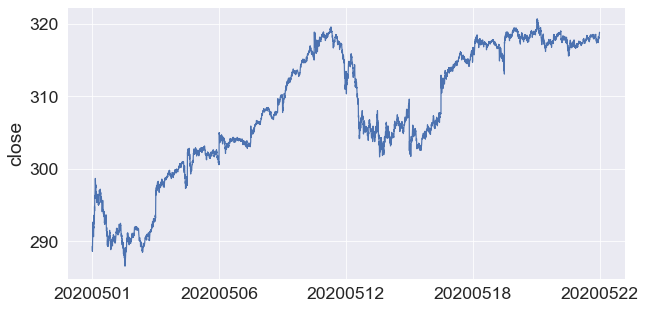

In [108]:
sns.set_context("paper", font_scale=2)
plt.figure(figsize=(10,5))
sns.lineplot(x = np.arange(in_sample_data[in_sample_data.Ticker=='AAPL'].shape[0]),#
             y=in_sample_data[in_sample_data.Ticker=='AAPL'].close)
numb_of_ticks = 5
plt.xticks(np.linspace(0,in_sample_data[in_sample_data.Ticker=='AAPL'].shape[0]-1,5).astype(int)
                ,in_sample_data[in_sample_data.Ticker=='AAPL'].loc[:,'Day'].values[np.linspace(0,in_sample_data[in_sample_data.Ticker=='AAPL'].shape[0]-1,5).astype(int)])
# plt.show()
plt.savefig('../../../Google Drev/Thesis/Figures/Apple_price_dev_entire_period.png',bbox_inches = 'tight')

## Prepping for models

In [8]:
N_VALIDATION = val_y.shape[0] #int(1e3)
N_TRAIN = train_y.shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 500

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X.shape[1]

N_TRAIN, N_VALIDATION, N_TRAIN + N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

(343090, 85800, 428890, 1340, 131, 670000)

## A Logistic Regression model in TF/Keras

In [55]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(1,
                       input_shape=(FEATURES,),
                       activation='sigmoid',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_auc', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks(run_id = 'first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=0) #(val_features, val_labels))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 99        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.5352,  auc:0.5034,  loss:0.8996,  val_accuracy:0.5456,  val_auc:0.5453,  val_loss:0.6876,  
....................................................................................................
Epoch: 100, accuracy:0.5480,  auc:0.5440,  loss:0.6873,  val_accuracy:0.5454,  val_auc:0.5459,  val_loss:0.6879,  
..................Restoring model weights from the end of the best epoch.
Epoch 00118: early stopping


In [56]:
model.evaluate(validate_ds,  val_y, verbose=2)

2682/2682 - 6s - loss: 0.6879 - accuracy: 0.5457 - auc: 0.5513


[0.6878659725189209, 0.5456876754760742, 0.5513222217559814]

In [11]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [12]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%tensorboard --logdir logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 9296.